In [1]:
# !gdown -O "app/test_data/raw/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
# !gdown -O "app/test_data/raw/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
# !gdown -O "app/test_data/raw/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
# !gdown -O "app/test_data/raw/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
# !gdown -O "app/test_data/raw/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [1]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/projects/sure-football-analysis


In [3]:
# from dotenv import load_dotenv
# load_dotenv(os.path.join(HOME, ".env"))

In [4]:
# from inference import get_model
from ultralytics import YOLO

# ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")
# PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"
# PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
PLAYER_DETECTION_MODEL = YOLO("app/models/yolo11_football_v2/weights/best.pt")

In [5]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [6]:
import supervision as sv
import numpy as np
from more_itertools import chunked
from tqdm import tqdm
import warnings
import torch

# Suppress FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Configuration
SOURCE_VIDEO_PATH = "app/test_data/raw/0bfacc_0.mp4"
BATCH_SIZE = 64
PLAYER_ID = 2
STRIDE = 30

# Frame generator
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

# Collect crops
crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

# Convert crops to pillow format
crops = [sv.cv2_to_pillow(crop) for crop in crops]

# Process crops in batches
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc="embedding extraction"):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

# Concatenate all embeddings
data = np.concatenate(data)

collecting crops: 0it [00:00, ?it/s]

0: 736x1280 20 players, 3 referees, 80.1ms
Speed: 17.5ms preprocess, 80.1ms inference, 241.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:02,  2.21s/it]


0: 736x1280 20 players, 3 referees, 32.9ms
Speed: 9.9ms preprocess, 32.9ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:02,  1.01it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.8ms
Speed: 7.3ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:02,  1.66it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 33.1ms
Speed: 9.6ms preprocess, 33.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:02,  2.39it/s]


0: 736x1280 20 players, 3 referees, 32.4ms
Speed: 7.0ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:02,  3.12it/s]


0: 736x1280 22 players, 3 referees, 32.4ms
Speed: 9.9ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:02,  3.86it/s]


0: 736x1280 21 players, 4 referees, 32.6ms
Speed: 6.9ms preprocess, 32.6ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:03,  4.56it/s]


0: 736x1280 20 players, 3 referees, 32.4ms
Speed: 9.8ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:03,  5.22it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.1ms
Speed: 7.5ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:03,  5.76it/s]


0: 736x1280 21 players, 3 referees, 32.8ms
Speed: 7.0ms preprocess, 32.8ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:03,  6.02it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.2ms
Speed: 11.2ms preprocess, 32.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:03,  6.44it/s]


0: 736x1280 22 players, 3 referees, 32.1ms
Speed: 7.0ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:03,  6.61it/s]


0: 736x1280 21 players, 3 referees, 32.1ms
Speed: 10.5ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:03,  6.83it/s]


0: 736x1280 20 players, 3 referees, 32.5ms
Speed: 6.6ms preprocess, 32.5ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:04,  6.81it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 32.1ms
Speed: 9.0ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:04,  7.00it/s]


0: 736x1280 20 players, 3 referees, 32.1ms
Speed: 11.0ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:04,  6.80it/s]


0: 736x1280 20 players, 3 referees, 32.4ms
Speed: 9.7ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:04,  7.08it/s]


0: 736x1280 20 players, 3 referees, 32.5ms
Speed: 10.2ms preprocess, 32.5ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:04,  7.07it/s]


0: 736x1280 21 players, 2 referees, 32.3ms
Speed: 11.0ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:04,  6.98it/s]


0: 736x1280 21 players, 2 referees, 32.5ms
Speed: 8.6ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:04,  7.16it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 32.3ms
Speed: 6.7ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:04,  7.19it/s]


0: 736x1280 20 players, 3 referees, 32.2ms
Speed: 10.4ms preprocess, 32.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:05,  7.29it/s]


0: 736x1280 21 players, 3 referees, 32.2ms
Speed: 11.0ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:05,  7.18it/s]


0: 736x1280 1 ball, 19 players, 3 referees, 32.1ms
Speed: 9.9ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:05,  7.16it/s]


0: 736x1280 1 ball, 18 players, 3 referees, 32.1ms
Speed: 6.7ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:05,  4.44it/s]
embedding extraction: 8it [00:03,  2.53it/s]


In [7]:
import umap
from sklearn.cluster import KMeans
from sports.common.team import TeamClassifier


REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    # result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    # detections = sv.Detections.from_inference(result)
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 20 players, 3 referees, 32.1ms
Speed: 8.4ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 32.6ms
Speed: 6.5ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:00,  9.54it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.1ms
Speed: 10.7ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:00,  8.00it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 32.1ms
Speed: 11.5ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:00,  7.70it/s]


0: 736x1280 20 players, 3 referees, 32.7ms
Speed: 6.7ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:00,  7.37it/s]


0: 736x1280 22 players, 3 referees, 32.3ms
Speed: 10.5ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:00,  7.31it/s]


0: 736x1280 21 players, 4 referees, 32.2ms
Speed: 6.9ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:00,  7.31it/s]


0: 736x1280 20 players, 3 referees, 32.2ms
Speed: 8.8ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:01,  7.41it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.2ms
Speed: 11.1ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:01,  7.34it/s]


0: 736x1280 21 players, 3 referees, 32.0ms
Speed: 6.9ms preprocess, 32.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:01,  7.16it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 32.7ms
Speed: 9.1ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:01,  7.34it/s]


0: 736x1280 22 players, 3 referees, 32.2ms
Speed: 7.7ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:01,  7.22it/s]


0: 736x1280 21 players, 3 referees, 32.6ms
Speed: 11.0ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:01,  7.30it/s]


0: 736x1280 20 players, 3 referees, 32.3ms
Speed: 6.8ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:01,  7.16it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 32.7ms
Speed: 10.6ms preprocess, 32.7ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:02,  7.23it/s]


0: 736x1280 20 players, 3 referees, 32.7ms
Speed: 6.8ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:02,  7.20it/s]


0: 736x1280 20 players, 3 referees, 32.2ms
Speed: 11.1ms preprocess, 32.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:02,  7.40it/s]


0: 736x1280 20 players, 3 referees, 32.2ms
Speed: 9.5ms preprocess, 32.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:02,  7.32it/s]


0: 736x1280 21 players, 2 referees, 32.0ms
Speed: 6.8ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:02,  7.22it/s]


0: 736x1280 21 players, 2 referees, 32.5ms
Speed: 8.2ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:02,  7.38it/s]


0: 736x1280 1 ball, 20 players, 3 referees, 32.4ms
Speed: 6.8ms preprocess, 32.4ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:02,  7.33it/s]


0: 736x1280 20 players, 3 referees, 32.0ms
Speed: 10.3ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:02,  7.40it/s]


0: 736x1280 21 players, 3 referees, 32.0ms
Speed: 11.1ms preprocess, 32.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:03,  7.27it/s]


0: 736x1280 1 ball, 19 players, 3 referees, 32.0ms
Speed: 10.7ms preprocess, 32.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:03,  7.21it/s]


0: 736x1280 1 ball, 18 players, 3 referees, 32.1ms
Speed: 9.9ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:03,  7.20it/s]
Embedding extraction: 19it [00:03,  4.83it/s]


In [ ]:
import joblib

MODEL_SAVE_DIR = "app/models/team_classifiers"  # Change this to your desired directory
import os
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# 1. Save SigLIP model and processor
EMBEDDINGS_MODEL.save_pretrained(f"{MODEL_SAVE_DIR}/siglip_model")
EMBEDDINGS_PROCESSOR.save_pretrained(f"{MODEL_SAVE_DIR}/siglip_model")

# 2. Save UMAP reducer
joblib.dump(REDUCER, f"{MODEL_SAVE_DIR}/umap_reducer.joblib")

# 3. Save KMeans model
joblib.dump(CLUSTERING_MODEL, f"{MODEL_SAVE_DIR}/kmeans_model.joblib")

# 4. Save TeamClassifier
# If it has a save method:
# team_classifier.save(f"{MODEL_SAVE_DIR}/team_classifier")
joblib.dump(team_classifier, f"{MODEL_SAVE_DIR}/team_classifier.joblib")

# Otherwise:
# np.save(f"{MODEL_SAVE_DIR}/team_classifier_embeddings.npy", team_classifier.embeddings_)
# np.save(f"{MODEL_SAVE_DIR}/team_classifier_labels.npy", team_classifier.labels_)

print("All models saved successfully!")

In [9]:
def calculate_average_color(frame: np.ndarray, detections: sv.Detections, central_fraction: float = 0.5) -> sv.Color | None:
    """Calculates the average color from the central region of detection boxes."""
    if len(detections) == 0: return None
    avg_colors = []
    height, width, _ = frame.shape
    for xyxy in detections.xyxy:
        x1, y1, x2, y2 = map(int, xyxy)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)
        if x1 >= x2 or y1 >= y2: continue
        box_w, box_h = x2 - x1, y2 - y1
        center_x, center_y = x1 + box_w // 2, y1 + box_h // 2
        central_w, central_h = int(box_w * central_fraction), int(box_h * central_fraction)
        cx1 = max(x1, center_x - central_w // 2)
        cy1 = max(y1, center_y - central_h // 2)
        cx2 = min(x2, center_x + central_w // 2)
        cy2 = min(y2, center_y + central_h // 2)
        if cx1 >= cx2 or cy1 >= cy2: continue
        crop = frame[cy1:cy2, cx1:cx2]
        if crop.size > 0:
            avg_bgr = cv2.mean(crop)[:3]
            avg_colors.append(avg_bgr)
    if not avg_colors: return None
    final_avg_bgr = np.mean(avg_colors, axis=0)
    b, g, r = map(int, final_avg_bgr)
    min_intensity = 50
    if r < min_intensity and g < min_intensity and b < min_intensity:
        r, g, b = min_intensity, min_intensity, min_intensity
    return sv.Color(r=r, g=g, b=b)

In [10]:
# ----- Color Calculation & Helper -----
DEFAULT_TEAM_A_COLOR = sv.Color.from_hex('#FF0000') # Red
DEFAULT_TEAM_B_COLOR = sv.Color.from_hex('#00FFFF') # Yellow
DEFAULT_REFEREE_COLOR = sv.Color.from_hex('#FFFF00') # Cyan 
FALLBACK_COLOR = sv.Color.from_hex('#808080') # Grey
COLOR_SIMILARITY_THRESHOLD = 50.0 # Max RGB distance diff to be considered ambiguous
# Team/Role Class IDs (assigned *after* classification)
TEAM_A_ID = 0 # Example ID for Team A (defends left goal in fallback)
TEAM_B_ID = 1 # Example ID for Team B (defends right goal in fallback)
REFEREE_TEAM_ID = 2 # Example ID for Referee


def color_distance(color1: sv.Color | None, color2: sv.Color | None) -> float:
    """Calculates Euclidean distance between two sv.Color objects in RGB space."""
    if color1 is None or color2 is None:
        return float('inf') # Return infinity if a color is missing
    # Ensure colors have r, g, b attributes
    if not all(hasattr(c, attr) for c in [color1, color2] for attr in ['r', 'g', 'b']):
         print(f"Warning: Invalid color object passed to color_distance: {color1}, {color2}")
         return float('inf')
    try:
        rgb1 = np.array([color1.r, color1.g, color1.b])
        rgb2 = np.array([color2.r, color2.g, color2.b])
        return np.linalg.norm(rgb1 - rgb2)
    except Exception as e:
        print(f"Error calculating color distance: {e}")
        return float('inf')

# ----- Enhanced Goalkeeper Resolution Function -----
def resolve_goalkeepers_team_id(
    frame: np.ndarray,
    goalkeepers: sv.Detections,
    team_a_color: sv.Color | None, # Pass calculated average color for Team A
    team_b_color: sv.Color | None, # Pass calculated average color for Team B
    color_similarity_threshold: float = COLOR_SIMILARITY_THRESHOLD # Use configured threshold
) -> np.ndarray:
    """
    Assigns team IDs to goalkeepers based primarily on color similarity to team average colors,
    with a positional fallback for ambiguous cases.
    """
    goalkeeper_team_ids = []
    if len(goalkeepers) == 0:
        return np.array([], dtype=int) # Return empty if no goalkeepers

    frame_height, frame_width, _ = frame.shape

    # Handle cases where team colors couldn't be calculated reliably
    valid_team_colors = team_a_color is not None and team_b_color is not None

    for i in range(len(goalkeepers)):
        # Process each goalkeeper individually
        gk_detection_single = goalkeepers[i:i+1] # Create Detections object with one GK
        gk_center_x, _ = gk_detection_single.get_anchors_coordinates(sv.Position.CENTER)[0]

        assigned_id = -1 # Default to invalid ID

        # 1. Try Color Similarity if possible
        if valid_team_colors:
            gk_color = calculate_average_color(frame, gk_detection_single)

            if gk_color is not None:
                dist_a = color_distance(gk_color, team_a_color)
                dist_b = color_distance(gk_color, team_b_color)

                # Check if colors are distinct enough
                if abs(dist_a - dist_b) > color_similarity_threshold:
                    assigned_id = TEAM_A_ID if dist_a < dist_b else TEAM_B_ID
                # else: Colors are ambiguous, will proceed to fallback

            # else: gk_color calculation failed, will proceed to fallback

        # 2. Positional Fallback (if color failed or was ambiguous)
        if assigned_id == -1:
            # print(f"GK {i} using positional fallback.") # Optional debug
            # Assign based on which half of the pitch they are on
            # Assumes Team A (ID 0) defends left goal, Team B (ID 1) defends right
            assigned_id = TEAM_A_ID if gk_center_x < frame_width / 2 else TEAM_B_ID

        goalkeeper_team_ids.append(assigned_id)

    return np.array(goalkeeper_team_ids)

In [14]:
import supervision as sv
from tqdm import tqdm
import numpy as np
from boxmot import BotSort # Using BoTSORT as requested
import cv2
from pathlib import Path
import torch
from collections import defaultdict, deque
import warnings
import logging
import traceback # Import traceback for detailed error printing
import os # Added for directory creation
import random # Added for sparkle effect
import math # Added for distance calculation

# Suppress most logging messages
logging.basicConfig(level=logging.WARNING) # Show only warnings and errors
logging.disable(logging.INFO) # Disable INFO messages specifically
warnings.filterwarnings('ignore', category=UserWarning, module='paddle')
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision') # Ignore potential torchvision warnings

# Attempt to import PaddleOCR
try:
    from paddleocr import PaddleOCR
    PADDLEOCR_AVAILABLE = True
except ImportError:
    print("Warning: PaddleOCR not found. Please install it (`pip install paddlepaddle paddleocr`). OCR functionality will be disabled.")
    PADDLEOCR_AVAILABLE = False


# ----- Configuration -----
SOURCE_VIDEO_PATH = "app/test_data/raw/sr2.mp4"
OUTPUT_VIDEO_PATH = "sr2_tracking_enhanced.mp4" # New output name
OCR_DEBUG_DIR = "ocr_debug_crops" # Directory to save OCR debug crops
DEVICE = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {DEVICE}")

# Create OCR debug directory if it doesn't exist
os.makedirs(OCR_DEBUG_DIR, exist_ok=True)
print(f"OCR debug crops will be saved to: {OCR_DEBUG_DIR}")

# Class IDs (initial detection model)
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# OCR Configuration
OCR_CONFIDENCE_THRESHOLD = 0.8
MIN_JERSEY_DIGITS = 1
MAX_JERSEY_DIGITS = 2

# ID Management Configuration
LOST_TRACK_MEMORY_SECONDS = 20
MISMATCH_CONSISTENCY_FRAMES = 3

# Ball Trail Configuration
BALL_TRAIL_SECONDS = 1
SPARKLE_COUNT = 3
SPARKLE_RADIUS = 2
SPARKLE_OFFSET = 3
MAX_BALL_DISTANCE_PER_FRAME = 400 # Max pixels ball can move between frames (TUNE THIS VALUE!)
# ----- Initialize PaddleOCR -----
ocr_model = None
if PADDLEOCR_AVAILABLE:
    try:
        ocr_model = PaddleOCR(use_angle_cls=False, lang='en', use_gpu=(DEVICE.type == 'cuda'), show_log=False)
        print("PaddleOCR initialized successfully.")
    except Exception as e:
        print(f"Error initializing PaddleOCR: {e}. Disabling OCR.")
        PADDLEOCR_AVAILABLE = False

# ----- OCR Function -----
def perform_ocr_on_crop(crop: np.ndarray) -> tuple[str | None, float | None]:
    """Performs OCR on a given crop, returning the best digit sequence and confidence."""
    if not PADDLEOCR_AVAILABLE or ocr_model is None or crop.size == 0:
        return None, None
    try:
        result = ocr_model.ocr(crop, cls=False)
        best_num, highest_conf = None, 0.0
        if result and result[0]:
             for res_item in result[0]:
                  if len(res_item) == 2 and isinstance(res_item[1], tuple) and len(res_item[1]) == 2:
                      text, confidence = res_item[1]
                      if (isinstance(text, str) and text.isdigit() and
                          MIN_JERSEY_DIGITS <= len(text) <= MAX_JERSEY_DIGITS and
                          isinstance(confidence, (float, int)) and
                          confidence > OCR_CONFIDENCE_THRESHOLD):
                           if confidence > highest_conf:
                               highest_conf, best_num = confidence, text
        return best_num, highest_conf if best_num else None
    except Exception as e:
        print(f"Error during PaddleOCR inference: {e}")
        return None, None

# ----- Annotation Parameters -----
ELLIPSE_THICKNESS = 1
LABEL_TEXT_COLOR = sv.Color.BLACK
LABEL_TEXT_POSITION = sv.Position.BOTTOM_CENTER
LABEL_TEXT_SCALE = 0.4
LABEL_TEXT_THICKNESS = 1
BALL_TRAIL_BASE_COLOR = (255, 255, 0) # Bright Cyan (BGR)
BALL_TRAIL_THICKNESS = 1
SPARKLE_BASE_INTENSITY = 150
SPARKLE_MAX_INTENSITY = 255
CURRENT_BALL_MARKER_RADIUS = 4
CURRENT_BALL_MARKER_COLOR = (255, 255, 255) # White (BGR)
CURRENT_BALL_MARKER_THICKNESS = -1 # Filled

# ----- Tracker Initialization -----
REID_WEIGHTS_PATH = Path('clip_market1501.pt')
tracker = BotSort(
    reid_weights=REID_WEIGHTS_PATH if REID_WEIGHTS_PATH.exists() else None,
    device=DEVICE,
    half=False,
    with_reid=REID_WEIGHTS_PATH.exists(),
)

# ----- Player ID & Ball Trail State -----
player_data = {}
recently_lost_jerseys = defaultdict(lambda: deque(maxlen=10))
ball_positions = None

# ----- Video Processing Setup -----
try:
    video_info = sv.VideoInfo.from_video_path(str(SOURCE_VIDEO_PATH))
    width, height, fps = video_info.width, video_info.height, video_info.fps
    total_frames = video_info.total_frames if video_info.total_frames else 0
    print(f"Video Info: {width}x{height}, FPS: {fps}, Total Frames: {total_frames if total_frames > 0 else 'Unknown'}")
except Exception as e:
    print(f"Warning: Could not get video info using supervision. Using OpenCV. Error: {e}")
    cap = cv2.VideoCapture(str(SOURCE_VIDEO_PATH))
    if not cap.isOpened(): raise IOError(f"Cannot open video file: {SOURCE_VIDEO_PATH}")
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS); total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)); cap.release()
    if not fps or fps <= 0: fps = 30
    if total_frames <= 0: total_frames = 0
    print(f"Fallback Video Info: {width}x{height}, FPS: {fps}, Total Frames: {total_frames if total_frames > 0 else 'Unknown'}")

if fps > 0:
    trail_maxlen = int(fps * BALL_TRAIL_SECONDS)
    ball_positions = deque(maxlen=trail_maxlen)
    print(f"Ball trail deque initialized with maxlen={trail_maxlen} ({BALL_TRAIL_SECONDS} seconds)")
else:
    print("Warning: Could not determine FPS. Ball trail disabled."); ball_positions = deque(maxlen=1)

LOST_TRACK_MEMORY_FRAMES = int(fps * LOST_TRACK_MEMORY_SECONDS) if fps > 0 else 30 * LOST_TRACK_MEMORY_SECONDS
print(f"Lost track memory set to {LOST_TRACK_MEMORY_FRAMES} frames ({LOST_TRACK_MEMORY_SECONDS} seconds)")

frame_generator = sv.get_video_frames_generator(source_path=str(SOURCE_VIDEO_PATH), stride=1)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(str(OUTPUT_VIDEO_PATH), fourcc, fps if fps > 0 else 30, (width, height))

# ----- Frame Processing Function -----
def process_frame(frame: np.ndarray, frame_idx: int):
    global player_data, recently_lost_jerseys, ball_positions

    # 1. Detection
    results = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, iou=0.5, device=DEVICE, verbose=False)
    if not results or len(results) == 0: return frame
    detections = sv.Detections.from_ultralytics(results[0])

    # 2. Pre-processing & Ball Position Update
    ball_detections = detections[detections.class_id == BALL_ID]
    people_detections = detections[detections.class_id != BALL_ID]

    # --- Update ball trail deque with outlier filtering ---
    if len(ball_detections) > 0 and ball_positions is not None:
        # Assuming single ball, take the first detection
        x1, y1, x2, y2 = ball_detections.xyxy[0]
        current_center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        is_valid_position = True # Assume valid initially
        if len(ball_positions) > 0:
            # Compare with the last known valid position
            prev_center = ball_positions[-1]
            # Check if prev_center is a valid tuple before calculating distance
            if isinstance(prev_center, tuple) and len(prev_center) == 2:
                distance = math.dist(current_center, prev_center)
                # Check if distance exceeds threshold
                if distance > MAX_BALL_DISTANCE_PER_FRAME:
                    is_valid_position = False
                    # Optional: Log the outlier detection
                    # print(f"[Frame {frame_idx}] Ball position outlier detected. Dist: {distance:.1f} > {MAX_BALL_DISTANCE_PER_FRAME}. Skipping update.")
            # else: Invalid format in deque? Treat current as valid start.

        # Append only if the position is considered valid
        if is_valid_position:
            ball_positions.append(current_center)
        # If not valid, ball_positions is simply not updated for this frame

    # 3. Team/Role Classification
    players_detections = people_detections[people_detections.class_id == PLAYER_ID]
    goalkeepers_detections = people_detections[people_detections.class_id == GOALKEEPER_ID]
    referees_detections = people_detections[people_detections.class_id == REFEREE_ID]

    # --- Player Classification ---
    classified_players = sv.Detections.empty()
    if len(players_detections) > 0:
        players_crops = []; valid_indices = []
        for i, xyxy in enumerate(players_detections.xyxy):
            crop = sv.crop_image(frame, xyxy)
            if crop is not None and crop.size > 0: players_crops.append(crop); valid_indices.append(i)
        if players_crops:
             predicted_team_ids = team_classifier.predict(players_crops)
             if predicted_team_ids is not None and len(predicted_team_ids) == len(players_crops):
                 assigned_ids = np.full(len(players_detections), -1, dtype=int)
                 for i, pred_id in enumerate(predicted_team_ids): assigned_ids[valid_indices[i]] = pred_id
                 valid_classification_mask = (assigned_ids != -1)
                 players_detections.class_id = assigned_ids
                 classified_players = players_detections[valid_classification_mask]

    # --- Calculate Dynamic Team Colors (needed before GK resolution) ---
    team_a_detections = classified_players[classified_players.class_id == TEAM_A_ID]
    team_b_detections = classified_players[classified_players.class_id == TEAM_B_ID]
    current_team_a_color = calculate_average_color(frame, team_a_detections) or DEFAULT_TEAM_A_COLOR
    current_team_b_color = calculate_average_color(frame, team_b_detections) or DEFAULT_TEAM_B_COLOR
    current_referee_color = DEFAULT_REFEREE_COLOR
    dynamic_color_map = { TEAM_A_ID: current_team_a_color, TEAM_B_ID: current_team_b_color, REFEREE_TEAM_ID: current_referee_color }

    # --- Goalkeeper Classification (using enhanced function) ---
    classified_gks = sv.Detections.empty()
    if len(goalkeepers_detections) > 0:
        # *** UPDATED CALL ***
        gk_team_ids = resolve_goalkeepers_team_id(
            frame,
            goalkeepers_detections,
            current_team_a_color, # Pass calculated color
            current_team_b_color  # Pass calculated color
        )
        if gk_team_ids is not None and len(gk_team_ids) == len(goalkeepers_detections):
            valid_gk_mask = (gk_team_ids != -1) # Filter out GKs where resolution failed
            goalkeepers_detections.class_id = gk_team_ids
            classified_gks = goalkeepers_detections[valid_gk_mask] # Only keep successfully classified GKs
        else:
            print(f"[Frame {frame_idx}] Warning: Goalkeeper resolution returned unexpected result.")


    # --- Referee Classification ---
    classified_refs = sv.Detections.empty()
    if len(referees_detections) > 0:
        ref_team_ids = np.full(len(referees_detections), REFEREE_TEAM_ID)
        referees_detections.class_id = ref_team_ids
        classified_refs = referees_detections

    # --- Merge Detections for Tracking ---
    detections_to_track = sv.Detections.merge([classified_players, classified_gks, classified_refs])

    # 4. Tracking using BoTSORT (Same logic)
    tracked_detections = sv.Detections.empty()
    current_frame_tracker_ids = set()
    if len(detections_to_track) > 0 and tracker is not None:
        boxmot_input = np.hstack((detections_to_track.xyxy, detections_to_track.confidence[:, np.newaxis], detections_to_track.class_id[:, np.newaxis]))
        try:
            tracks = tracker.update(boxmot_input, frame)
            if tracks.shape[0] > 0:
                tracked_detections = sv.Detections(xyxy=tracks[:, 0:4], tracker_id=tracks[:, 4].astype(int), confidence=tracks[:, 5], class_id=tracks[:, 6].astype(int))
                current_frame_tracker_ids = set(tracked_detections.tracker_id)
        except Exception as e: print(f"[Frame {frame_idx}] Error during tracker update: {e}"); tracked_detections = sv.Detections.empty()
    elif tracker is not None:
         try: tracker.update(np.empty((0, 6)), frame)
         except Exception as e: print(f"[Frame {frame_idx}] Error updating tracker with empty input: {e}")

    # 5. OCR and Player ID Management (Label Generation)
    final_labels = []
    current_player_data = {}
    if len(tracked_detections) > 0:
        for i in range(len(tracked_detections)):
            track_id = tracked_detections.tracker_id[i]; team_id = tracked_detections.class_id[i]; bbox = tracked_detections.xyxy[i]
            x1, y1, x2, y2 = map(int, bbox); x1, y1 = max(0, x1), max(0, y1); x2, y2 = min(width, x2), min(height, y2)
            detected_jersey_num, ocr_confidence = None, None; player_crop, gray_crop = None, None
            if x1 < x2 and y1 < y2:
                player_crop = frame[y1:y2, x1:x2]; gray_crop = cv2.cvtColor(player_crop, cv2.COLOR_BGR2GRAY)
                detected_jersey_num, ocr_confidence = perform_ocr_on_crop(gray_crop)
                if detected_jersey_num is not None and player_crop is not None and gray_crop is not None:
                    try:
                        player_filename = os.path.join(OCR_DEBUG_DIR, f"frame{frame_idx}_track{track_id}_player.png")
                        ocr_input_filename = os.path.join(OCR_DEBUG_DIR, f"frame{frame_idx}_track{track_id}_ocr_input.png")
                        cv2.imwrite(player_filename, player_crop); cv2.imwrite(ocr_input_filename, gray_crop)
                    except Exception as write_e: print(f"[Frame {frame_idx}] Error saving OCR debug crop for track {track_id}: {write_e}")
            assigned_jersey_id = None
            if track_id in player_data:
                p_data = player_data[track_id]; p_data["last_seen"] = frame_idx; p_data["team_id"] = team_id
                current_jersey_id = p_data["jersey_id"]; mismatch_history = p_data["mismatch_history"]
                if detected_jersey_num is not None:
                    if current_jersey_id is None or detected_jersey_num == current_jersey_id: p_data["jersey_id"] = detected_jersey_num; p_data["jersey_confidence"] = ocr_confidence; mismatch_history.clear()
                    else:
                        mismatch_history.append(detected_jersey_num)
                        if len(mismatch_history) >= MISMATCH_CONSISTENCY_FRAMES and all(num == detected_jersey_num for num in mismatch_history): p_data["jersey_id"] = detected_jersey_num; p_data["jersey_confidence"] = ocr_confidence; mismatch_history.clear()
                else: mismatch_history.clear()
                assigned_jersey_id = p_data["jersey_id"]; current_player_data[track_id] = p_data
            else:
                found_match = False
                if detected_jersey_num is not None and detected_jersey_num in recently_lost_jerseys:
                    potential_matches = []
                    for lost_track_info in reversed(recently_lost_jerseys[detected_jersey_num]):
                        time_diff = frame_idx - lost_track_info["last_seen"]
                        if time_diff < LOST_TRACK_MEMORY_FRAMES and lost_track_info["team_id"] == team_id: potential_matches.append((lost_track_info, time_diff))
                    if potential_matches:
                        potential_matches.sort(key=lambda x: x[1]); best_match_info, _ = potential_matches[0]; assigned_jersey_id = detected_jersey_num
                        p_data = {"jersey_id": assigned_jersey_id, "jersey_confidence": ocr_confidence, "last_seen": frame_idx, "team_id": team_id, "mismatch_history": deque(maxlen=MISMATCH_CONSISTENCY_FRAMES)}
                        current_player_data[track_id] = p_data
                        try: recently_lost_jerseys[detected_jersey_num].remove(best_match_info)
                        except ValueError: pass
                        found_match = True
                if not found_match:
                    assigned_jersey_id = detected_jersey_num
                    current_player_data[track_id] = {"jersey_id": assigned_jersey_id, "jersey_confidence": ocr_confidence if detected_jersey_num is not None else None, "last_seen": frame_idx, "team_id": team_id, "mismatch_history": deque(maxlen=MISMATCH_CONSISTENCY_FRAMES)}
            if team_id == TEAM_A_ID: team_prefix = "T1"
            elif team_id == TEAM_B_ID: team_prefix = "T2"
            elif team_id == REFEREE_TEAM_ID: team_prefix = "Ref"
            else: team_prefix = f"T{team_id}"
            base_label = f"{team_prefix} P{track_id}"; display_id = base_label
            if assigned_jersey_id is not None: display_id = f"{base_label} #{assigned_jersey_id}"
            final_labels.append(display_id)

    # 6. Update Global Player Data & Handle Lost Tracks (Same as before)
    lost_tracker_ids = set(player_data.keys()) - current_frame_tracker_ids
    for lost_id in lost_tracker_ids:
        lost_info = player_data[lost_id]
        if lost_info.get("jersey_id") is not None: recently_lost_jerseys[lost_info["jersey_id"]].append({"tracker_id": lost_id, "last_seen": lost_info["last_seen"], "team_id": lost_info["team_id"]})
    if frame_idx > 0 and fps > 0 and frame_idx % (int(fps) * 60) == 0:
        for jersey_num in list(recently_lost_jerseys.keys()):
            q = recently_lost_jerseys[jersey_num]
            valid_entries = deque([entry for entry in q if (frame_idx - entry["last_seen"]) < LOST_TRACK_MEMORY_FRAMES * 2], maxlen=10)
            if valid_entries: recently_lost_jerseys[jersey_num] = valid_entries
            else: del recently_lost_jerseys[jersey_num]
    player_data = current_player_data

    # 7. Annotation
    annotated_frame = frame.copy()

    # --- Annotate "Magical" Ball Trail ---
    if ball_positions is not None and len(ball_positions) >= 2:
        num_points = len(ball_positions)
        for i in range(1, num_points):
            pt1 = ball_positions[i-1]; pt2 = ball_positions[i]
            if isinstance(pt1, tuple) and isinstance(pt2, tuple) and len(pt1) == 2 and len(pt2) == 2:
                 cv2.line(annotated_frame, pt1, pt2, BALL_TRAIL_BASE_COLOR, BALL_TRAIL_THICKNESS)
                 alpha_fraction = (i - 1) / max(1, num_points - 1)
                 sparkle_intensity = int(SPARKLE_BASE_INTENSITY + (SPARKLE_MAX_INTENSITY - SPARKLE_BASE_INTENSITY) * alpha_fraction)
                 sparkle_color = (sparkle_intensity, sparkle_intensity, sparkle_intensity)
                 for _ in range(SPARKLE_COUNT):
                     offset_x = random.randint(-SPARKLE_OFFSET, SPARKLE_OFFSET); offset_y = random.randint(-SPARKLE_OFFSET, SPARKLE_OFFSET)
                     sparkle_pt = (pt2[0] + offset_x, pt2[1] + offset_y)
                     cv2.circle(annotated_frame, sparkle_pt, SPARKLE_RADIUS, sparkle_color, -1)

    # --- Annotate Current Ball Position ---
    if ball_positions is not None and len(ball_positions) > 0:
         last_pos = ball_positions[-1]
         if isinstance(last_pos, tuple) and len(last_pos) == 2:
              cv2.circle(annotated_frame, last_pos, CURRENT_BALL_MARKER_RADIUS, CURRENT_BALL_MARKER_COLOR, CURRENT_BALL_MARKER_THICKNESS)

    # --- Annotate Tracked People ---
    if len(tracked_detections) > 0:
        if len(final_labels) == len(tracked_detections):
            unique_team_ids = np.unique(tracked_detections.class_id)
            for current_team_id in unique_team_ids:
                team_mask = (tracked_detections.class_id == current_team_id); team_detections = tracked_detections[team_mask]
                team_labels = [label for i, label in enumerate(final_labels) if team_mask[i]]
                if len(team_detections) == 0: continue
                team_color = dynamic_color_map.get(current_team_id, FALLBACK_COLOR)
                temp_ellipse_annotator = sv.EllipseAnnotator(color=team_color, thickness=ELLIPSE_THICKNESS)
                temp_label_annotator = sv.LabelAnnotator(color=team_color, text_color=LABEL_TEXT_COLOR, text_position=LABEL_TEXT_POSITION, text_scale=LABEL_TEXT_SCALE, text_thickness=LABEL_TEXT_THICKNESS)
                try:
                    annotated_frame = temp_ellipse_annotator.annotate(annotated_frame, team_detections)
                    annotated_frame = temp_label_annotator.annotate(annotated_frame, team_detections, team_labels)
                except Exception as e: print(f"[Frame {frame_idx}] Error during annotation for team {current_team_id} (Color: {team_color.as_hex()}): {e}")

    return annotated_frame

# ----- Main Video Processing Loop -----
try:
    tqdm_total = total_frames if total_frames and total_frames > 0 else None
    with tqdm(total=tqdm_total, desc="Processing video", unit="frame") as pbar:
        for frame_idx, frame in enumerate(frame_generator):
            if frame is None: print(f"\nWarning: Received None frame at index {frame_idx}, ending processing."); break
            try:
                annotated_frame = process_frame(frame, frame_idx)
                if annotated_frame is not None: video_writer.write(annotated_frame)
                else: print(f"\nError: process_frame returned None for frame {frame_idx}. Writing original frame."); video_writer.write(frame)
            except Exception as e: print(f"\n--- CRITICAL ERROR processing frame {frame_idx}: {e} ---"); traceback.print_exc(); print("Attempting to continue and write original frame..."); video_writer.write(frame)
            pbar.update(1)
except KeyboardInterrupt: print("\nProcessing interrupted by user.")
except Exception as e: print(f"\n--- UNHANDLED EXCEPTION in main loop: {e} ---"); traceback.print_exc()
finally:
    video_writer.release()
    print(f"\nFinished processing. Annotated video saved to: {OUTPUT_VIDEO_PATH}")
    if DEVICE.type == 'cuda':
        try: torch.cuda.empty_cache(); print("CUDA cache cleared.")
        except Exception as e: print(f"Error clearing CUDA cache: {e}")
    print("Done.")

Using device: cuda:0
OCR debug crops will be saved to: ocr_debug_crops


2025-04-21 09:16:58.824 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.5 🚀 Python-3.11.11 torch-2.5.1+cu121
CUDA:0 (NVIDIA L4, 22478MiB)


PaddleOCR initialized successfully.
Resized position embedding: %s to %s torch.Size([197, 768]) torch.Size([129, 768])
Position embedding resize to height:16 width: 8


2025-04-21 09:17:00.692 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from clip_market1501.pt


Video Info: 1920x970, FPS: 30, Total Frames: 797
Ball trail deque initialized with maxlen=30 (1 seconds)
Lost track memory set to 600 frames (20 seconds)


Embedding extraction: 1it [00:00, 11.71it/s]:00<?, ?frame/s]
Embedding extraction: 1it [00:00, 10.73it/s]:00<05:31,  2.40frame/s]
Embedding extraction: 1it [00:00, 10.68it/s]:00<04:54,  2.70frame/s]
Embedding extraction: 1it [00:00, 10.83it/s]:01<04:39,  2.84frame/s]
Embedding extraction: 1it [00:00, 10.75it/s]:01<04:28,  2.95frame/s]
Embedding extraction: 1it [00:00, 11.68it/s]:01<04:22,  3.01frame/s]
Embedding extraction: 1it [00:00, 10.89it/s]:02<04:19,  3.05frame/s]
Embedding extraction: 1it [00:00, 10.97it/s]:02<04:17,  3.07frame/s]
Embedding extraction: 1it [00:00, 10.84it/s]:02<04:15,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.92it/s]:03<04:15,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.90it/s]0:03<04:15,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.74it/s]0:03<04:15,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.85it/s]0:03<04:14,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.87it/s]0:04<04:14,  3.08frame/s]
Embedding extraction: 1it [00:00, 10.8


Finished processing. Annotated video saved to: sr2_tracking_enhanced.mp4
CUDA cache cleared.
Done.


### Advanced Analytics

In [8]:
import supervision as sv
from tqdm import tqdm
import numpy as np
from boxmot import BotSort # Using BoTSORT as requested
import cv2
from pathlib import Path
import torch
from collections import defaultdict, deque
import warnings
import logging
import traceback # Import traceback for detailed error printing
import os # Added for directory creation
import random # Added for sparkle effect
import math # Added for distance and speed calculation

# Suppress most logging messages
logging.basicConfig(level=logging.WARNING) # Show only warnings and errors
logging.disable(logging.INFO) # Disable INFO messages specifically
warnings.filterwarnings('ignore', category=UserWarning, module='paddle')
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision') # Ignore potential torchvision warnings

# Attempt to import PaddleOCR
try:
    from paddleocr import PaddleOCR
    PADDLEOCR_AVAILABLE = True
except ImportError:
    print("Warning: PaddleOCR not found. Please install it (`pip install paddlepaddle paddleocr`). OCR functionality will be disabled.")
    PADDLEOCR_AVAILABLE = False


# ----- Configuration -----
SOURCE_VIDEO_PATH = "app/test_data/raw/0bfacc_0.mp4"
OUTPUT_VIDEO_PATH = "0bfacc_0_tracking_analysis_overlap_possession.mp4" # New output name
OCR_DEBUG_DIR = "ocr_debug_crops" # Directory to save OCR debug crops
DEVICE = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {DEVICE}")

# Create OCR debug directory if it doesn't exist
os.makedirs(OCR_DEBUG_DIR, exist_ok=True)
print(f"OCR debug crops will be saved to: {OCR_DEBUG_DIR}")

# Class IDs (initial detection model)
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# OCR Configuration
OCR_CONFIDENCE_THRESHOLD = 0.8
MIN_JERSEY_DIGITS = 1
MAX_JERSEY_DIGITS = 2

# ID Management Configuration
LOST_TRACK_MEMORY_SECONDS = 20
MISMATCH_CONSISTENCY_FRAMES = 3

# Ball Trail Configuration
BALL_TRAIL_SECONDS = 2
SPARKLE_COUNT = 3
SPARKLE_RADIUS = 2
SPARKLE_OFFSET = 3
MAX_BALL_DISTANCE_PER_FRAME = 400 # Max pixels ball can move between frames (TUNE THIS VALUE!)

# Analysis Configuration
ANALYSIS_OVERLAY_POS = (10, -10) # (x, y) from bottom-left corner (negative y counts from bottom)
ANALYSIS_OVERLAY_SCALE = 0.5 # Increased font scale
ANALYSIS_OVERLAY_THICKNESS = 1
ANALYSIS_OVERLAY_BG_COLOR = (0, 0, 0)
ANALYSIS_OVERLAY_TEXT_COLOR = (255, 255, 255)
ANALYSIS_OVERLAY_ALPHA = 0.6 # Background transparency
# ANALYSIS_TARGET_TRACK_ID_FOR_DISTANCE = 1 # Example: Track distance for player with tracker_id 1 (Removed as we now track team total)
ANALYSIS_BOX_PADDING_X = 35 # Further Increased padding for a wider box
ANALYSIS_BOX_PADDING_Y = 25 # Further Increased padding for a taller box

# ----- Initialize PaddleOCR -----
ocr_model = None
if PADDLEOCR_AVAILABLE:
    try:
        ocr_model = PaddleOCR(use_angle_cls=False, lang='en', use_gpu=(DEVICE.type == 'cuda'), show_log=False)
        print("PaddleOCR initialized successfully.")
    except Exception as e:
        print(f"Error initializing PaddleOCR: {e}. Disabling OCR.")
        PADDLEOCR_AVAILABLE = False

# ----- Helper Functions -----
def perform_ocr_on_crop(crop: np.ndarray) -> tuple[str | None, float | None]:
    """Performs OCR on a given crop, returning the best digit sequence and confidence."""
    if not PADDLEOCR_AVAILABLE or ocr_model is None or crop.size == 0:
        return None, None
    try:
        result = ocr_model.ocr(crop, cls=False)
        best_num, highest_conf = None, 0.0
        if result and result[0]:
             for res_item in result[0]:
                 if len(res_item) == 2 and isinstance(res_item[1], tuple) and len(res_item[1]) == 2:
                     text, confidence = res_item[1]
                     if (isinstance(text, str) and text.isdigit() and
                         MIN_JERSEY_DIGITS <= len(text) <= MAX_JERSEY_DIGITS and
                         isinstance(confidence, (float, int)) and
                         confidence > OCR_CONFIDENCE_THRESHOLD):
                          if confidence > highest_conf:
                              highest_conf, best_num = confidence, text
        return best_num, highest_conf if best_num else None
    except Exception as e:
        # print(f"Error during PaddleOCR inference: {e}")
        # traceback.print_exc() # Print full traceback for debugging
        return None, None

def check_overlap(box1, box2):
    """Checks if two bounding boxes (xyxy format) overlap."""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    # Check for non-overlap condition
    if x2_1 < x1_2 or x2_2 < x1_1 or y2_1 < y1_2 or y2_2 < y1_1:
        return False
    return True # Boxes overlap

# ----- Color Calculation & Helper -----
DEFAULT_TEAM_A_COLOR = sv.Color.from_hex('#FF0000') # Red
DEFAULT_TEAM_B_COLOR = sv.Color.from_hex('#00FFFF') # Yellow
DEFAULT_REFEREE_COLOR = sv.Color.from_hex('#00FF00') # Green
FALLBACK_COLOR = sv.Color.from_hex('#808080') # Grey
COLOR_SIMILARITY_THRESHOLD = 50.0 # Max RGB distance diff to be considered ambiguous
# Team/Role Class IDs (assigned *after* classification)
TEAM_A_ID = 0 # Example ID for Team A (defends left goal in fallback)
TEAM_B_ID = 1 # Example ID for Team B (defends right goal in fallback)
REFEREE_TEAM_ID = 2 # Example ID for Referee

def calculate_average_color(frame: np.ndarray, detections: sv.Detections, central_fraction: float = 0.5) -> sv.Color | None:
    """Calculates the average color from the central region of detection boxes."""
    if len(detections) == 0: return None
    avg_colors = []
    height, width, _ = frame.shape
    for xyxy in detections.xyxy:
        x1, y1, x2, y2 = map(int, xyxy)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)
        if x1 >= x2 or y1 >= y2: continue
        box_w, box_h = x2 - x1, y2 - y1
        center_x, center_y = x1 + box_w // 2, y1 + box_h // 2
        central_w, central_h = int(box_w * central_fraction), int(box_h * central_fraction)
        cx1 = max(x1, center_x - central_w // 2)
        cy1 = max(y1, center_y - central_h // 2)
        cx2 = min(x2, center_x + central_w // 2)
        cy2 = min(y2, center_y + central_h // 2)
        if cx1 >= cx2 or cy1 >= cy2: continue
        crop = frame[cy1:cy2, cx1:cx2]
        if crop.size > 0:
            avg_bgr = cv2.mean(crop)[:3]
            avg_colors.append(avg_bgr)
    if not avg_colors: return None
    final_avg_bgr = np.mean(avg_colors, axis=0)
    b, g, r = map(int, final_avg_bgr)
    min_intensity = 50
    if r < min_intensity and g < min_intensity and b < min_intensity:
        r, g, b = min_intensity, min_intensity, min_intensity
    return sv.Color(r=r, g=g, b=b)


def color_distance(color1: sv.Color | None, color2: sv.Color | None) -> float:
    """Calculates Euclidean distance between two sv.Color objects in RGB space."""
    if color1 is None or color2 is None:
        return float('inf') # Return infinity if a color is missing
    # Ensure colors have r, g, b attributes
    if not all(hasattr(c, attr) for c in [color1, color2] for attr in ['r', 'g', 'b']):
         print(f"Warning: Invalid color object passed to color_distance: {color1}, {color2}")
         return float('inf')
    try:
        rgb1 = np.array([color1.r, color1.g, color1.b])
        rgb2 = np.array([color2.r, color2.g, color2.b])
        return np.linalg.norm(rgb1 - rgb2)
    except Exception as e:
        print(f"Error calculating color distance: {e}")
        return float('inf')

# ----- Enhanced Goalkeeper Resolution Function -----
def resolve_goalkeepers_team_id(
    frame: np.ndarray,
    goalkeepers: sv.Detections,
    team_a_color: sv.Color | None, # Pass calculated average color for Team A
    team_b_color: sv.Color | None, # Pass calculated average color for Team B
    color_similarity_threshold: float = COLOR_SIMILARITY_THRESHOLD # Use configured threshold
) -> np.ndarray:
    """
    Assigns team IDs to goalkeepers based primarily on color similarity to team average colors,
    with a positional fallback for ambiguous cases.
    """
    goalkeeper_team_ids = []
    if len(goalkeepers) == 0:
        return np.array([], dtype=int) # Return empty if no goalkeepers

    frame_height, frame_width, _ = frame.shape

    # Handle cases where team colors couldn't be calculated reliably
    valid_team_colors = team_a_color is not None and team_b_color is not None

    for i in range(len(goalkeepers)):
        # Process each goalkeeper individually
        gk_detection_single = goalkeepers[i:i+1] # Create Detections object with one GK
        # Use BOTTOM_CENTER as anchor for positional fallback (less likely to be occluded)
        try:
             gk_anchor = gk_detection_single.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
             if gk_anchor.shape[0] > 0:
                 gk_center_x = gk_anchor[0, 0]
             else:
                 # Fallback to box center if anchor fails
                 xyxy = gk_detection_single.xyxy[0]
                 gk_center_x = (xyxy[0] + xyxy[2]) / 2
        except Exception: # Handle potential errors in get_anchors_coordinates
             xyxy = gk_detection_single.xyxy[0]
             gk_center_x = (xyxy[0] + xyxy[2]) / 2


        assigned_id = -1 # Default to invalid ID

        # 1. Try Color Similarity if possible
        if valid_team_colors:
            gk_color = calculate_average_color(frame, gk_detection_single)

            if gk_color is not None:
                dist_a = color_distance(gk_color, team_a_color)
                dist_b = color_distance(gk_color, team_b_color)

                # Check if colors are distinct enough
                if abs(dist_a - dist_b) > color_similarity_threshold:
                    assigned_id = TEAM_A_ID if dist_a < dist_b else TEAM_B_ID
                # else: Colors are ambiguous, will proceed to fallback

            # else: gk_color calculation failed, will proceed to fallback

        # 2. Positional Fallback (if color failed or was ambiguous)
        if assigned_id == -1:
            # print(f"GK {i} using positional fallback.") # Optional debug
            # Assign based on which half of the pitch they are on
            # Assumes Team A (ID 0) defends left goal, Team B (ID 1) defends right
            assigned_id = TEAM_A_ID if gk_center_x < frame_width / 2 else TEAM_B_ID

        goalkeeper_team_ids.append(assigned_id)

    return np.array(goalkeeper_team_ids)


# ----- Annotation Parameters -----
ELLIPSE_THICKNESS = 1
LABEL_TEXT_COLOR = sv.Color.BLACK
LABEL_TEXT_POSITION = sv.Position.BOTTOM_CENTER
LABEL_TEXT_SCALE = 0.4 # Keep label scale small
LABEL_TEXT_THICKNESS = 1
BALL_TRAIL_BASE_COLOR = (255, 255, 0) # Bright Cyan (BGR)
BALL_TRAIL_THICKNESS = 1
SPARKLE_BASE_INTENSITY = 150
SPARKLE_MAX_INTENSITY = 255
CURRENT_BALL_MARKER_RADIUS = 4
CURRENT_BALL_MARKER_COLOR = (255, 255, 255) # White (BGR)
CURRENT_BALL_MARKER_THICKNESS = -1 # Filled

# ----- Tracker Initialization -----
REID_WEIGHTS_PATH = Path('clip_market1501.pt') # Make sure this path is correct or remove if not using ReID
tracker = None
try:
    tracker = BotSort(
        reid_weights=REID_WEIGHTS_PATH if REID_WEIGHTS_PATH.exists() else None,
        device=DEVICE,
        half=False, # Set to True if using FP16 models/inference
        with_reid=REID_WEIGHTS_PATH.exists(),
    )
    print(f"BoTSORT tracker initialized. ReID enabled: {REID_WEIGHTS_PATH.exists()}")
except Exception as e:
    print(f"Error initializing BoTSORT tracker: {e}")
    print("Tracking will be disabled.")


# ----- Player ID, Ball Trail & Analysis State -----
player_data = {} # Stores data per track_id: { 'jersey_id', 'jersey_conf', 'last_seen', 'team_id', 'mismatch_hist', 'prev_center', 'prev_frame', 'total_distance' }
recently_lost_jerseys = defaultdict(lambda: deque(maxlen=10)) # Stores info about lost tracks with known jerseys
ball_positions = None # Deque for ball trail
previous_ball_center = None # For ball speed calculation
previous_ball_frame = None # For ball speed calculation
possession_frames_A = 0 # Total frames Team A had possession
possession_frames_B = 0 # Total frames Team B had possession
total_distance_A = 0.0 # Total distance covered by Team A players (pixels)
total_distance_B = 0.0 # Total distance covered by Team B players (pixels)

# ----- Video Processing Setup -----
width, height, fps, total_frames = 0, 0, 0, 0
try:
    video_info = sv.VideoInfo.from_video_path(str(SOURCE_VIDEO_PATH))
    width, height, fps = video_info.width, video_info.height, video_info.fps
    total_frames = video_info.total_frames if video_info.total_frames else 0
    print(f"Video Info: {width}x{height}, FPS: {fps}, Total Frames: {total_frames if total_frames > 0 else 'Unknown'}")
except Exception as e:
    print(f"Warning: Could not get video info using supervision. Using OpenCV. Error: {e}")
    cap = cv2.VideoCapture(str(SOURCE_VIDEO_PATH))
    if not cap.isOpened(): raise IOError(f"Cannot open video file: {SOURCE_VIDEO_PATH}")
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS); total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)); cap.release()
    if not fps or fps <= 0: fps = 30 # Assign a default FPS if detection fails
    if total_frames <= 0: total_frames = 0
    print(f"Fallback Video Info: {width}x{height}, FPS: {fps}, Total Frames: {total_frames if total_frames > 0 else 'Unknown'}")

if width == 0 or height == 0:
     raise ValueError("Could not determine video dimensions. Exiting.")

if fps > 0:
    trail_maxlen = int(fps * BALL_TRAIL_SECONDS)
    ball_positions = deque(maxlen=trail_maxlen)
    print(f"Ball trail deque initialized with maxlen={trail_maxlen} ({BALL_TRAIL_SECONDS} seconds)")
else:
    print("Warning: Could not determine FPS. Ball trail and speed calculations might be inaccurate or disabled.");
    ball_positions = deque(maxlen=30) # Default maxlen if FPS unknown

LOST_TRACK_MEMORY_FRAMES = int(fps * LOST_TRACK_MEMORY_SECONDS) if fps > 0 else 30 * LOST_TRACK_MEMORY_SECONDS
print(f"Lost track memory set to {LOST_TRACK_MEMORY_FRAMES} frames ({LOST_TRACK_MEMORY_SECONDS} seconds)")

frame_generator = sv.get_video_frames_generator(source_path=str(SOURCE_VIDEO_PATH), stride=1)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Or use 'XVID', 'avc1' etc. depending on system codecs
video_writer = cv2.VideoWriter(str(OUTPUT_VIDEO_PATH), fourcc, fps if fps > 0 else 30, (width, height))

# ----- Analysis Overlay Function -----
def draw_analysis_overlay(frame: np.ndarray, analysis_data: dict):
    """Draws the analysis data onto the frame in a semi-transparent box."""
    h, w, _ = frame.shape
    box_x = ANALYSIS_OVERLAY_POS[0]
    box_y = h + ANALYSIS_OVERLAY_POS[1] # Calculate y from bottom

    # Updated text lines for new analysis
    text_lines = [
        f"Possession T1: {analysis_data.get('possession_perc_A', 'N/A')}%",
        f"Possession T2: {analysis_data.get('possession_perc_B', 'N/A')}%",
        f"Total Dist T1: {analysis_data.get('total_dist_A', 'N/A')} kpx", # Show kpx (kilo-pixels)
        f"Total Dist T2: {analysis_data.get('total_dist_B', 'N/A')} kpx",
        f"Ball Speed: {analysis_data.get('ball_speed', 'N/A')} px/f",
        # f"Avg Speed T1: {analysis_data.get('avg_speed_A', 'N/A')} px/f", # Optional: Keep avg speed if desired
        # f"Avg Speed T2: {analysis_data.get('avg_speed_B', 'N/A')} px/f",
    ]

    # Calculate text size and box dimensions with increased padding and scale
    text_sizes = [cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, ANALYSIS_OVERLAY_SCALE, ANALYSIS_OVERLAY_THICKNESS)[0] for line in text_lines]
    line_height = text_sizes[0][1] + 7 # Increased padding between lines due to larger font
    max_text_width = max(size[0] for size in text_sizes) if text_sizes else 0
    box_w = max_text_width + ANALYSIS_BOX_PADDING_X # Use configured padding
    box_h = len(text_lines) * line_height + ANALYSIS_BOX_PADDING_Y # Use configured padding

    # Adjust box_y to be the top-left corner y-coordinate
    box_y -= box_h

    # Ensure box stays within frame boundaries
    box_x = max(0, box_x)
    box_y = max(0, box_y)
    box_x2 = min(w, box_x + box_w)
    box_y2 = min(h, box_y + box_h)
    box_w = box_x2 - box_x
    box_h = box_y2 - box_y

    if box_w <= 0 or box_h <= 0: return # Don't draw if box is invalid

    try:
        # Create overlay rectangle
        sub_img = frame[box_y:box_y+box_h, box_x:box_x+box_w]
        black_rect = np.zeros(sub_img.shape, dtype=np.uint8)
        res = cv2.addWeighted(sub_img, 1 - ANALYSIS_OVERLAY_ALPHA, black_rect, ANALYSIS_OVERLAY_ALPHA, 1.0)
        frame[box_y:box_y+box_h, box_x:box_x+box_w] = res

        # Draw text
        current_y = box_y + line_height # Start position for first line
        for line in text_lines:
            cv2.putText(frame, line, (box_x + 15, current_y - 7), cv2.FONT_HERSHEY_SIMPLEX, # Adjusted text position slightly
                        ANALYSIS_OVERLAY_SCALE, ANALYSIS_OVERLAY_TEXT_COLOR, ANALYSIS_OVERLAY_THICKNESS, cv2.LINE_AA)
            current_y += line_height
    except Exception as e:
        print(f"Error drawing analysis overlay: {e}")
        # traceback.print_exc()


# ----- Frame Processing Function -----
def process_frame(frame: np.ndarray, frame_idx: int):
    # Make state variables global to update them
    global player_data, recently_lost_jerseys, ball_positions, previous_ball_center, previous_ball_frame
    global possession_frames_A, possession_frames_B, total_distance_A, total_distance_B

    # --- Analysis Data Initialization ---
    analysis_data = {
        'possession_perc_A': '0.0', # Initialize percentages
        'possession_perc_B': '0.0',
        'total_dist_A': '0.0',     # Initialize distances
        'total_dist_B': '0.0',
        'ball_speed': 'N/A',
        'avg_speed_A': 'N/A',      # Keep avg speed calculation if needed later
        'avg_speed_B': 'N/A',
    }
    current_ball_center = None # Reset for this frame
    current_ball_bbox = None   # Store ball bbox for overlap check

    # 1. Detection
    results = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3, iou=0.5, device=DEVICE, verbose=False)
    if not results or len(results) == 0: return frame # Return original frame if no detections
    try:
        detections = sv.Detections.from_ultralytics(results[0])
    except Exception as e:
        print(f"[Frame {frame_idx}] Error converting detections: {e}")
        return frame # Return original frame on error

    # 2. Pre-processing & Ball Position/Speed Update
    ball_detections = detections[detections.class_id == BALL_ID]
    people_detections = detections[detections.class_id != BALL_ID]

    # --- Update ball trail deque with outlier filtering ---
    if len(ball_detections) > 0 and ball_positions is not None:
        # Assuming single ball, take the detection with highest confidence
        best_ball_idx = np.argmax(ball_detections.confidence)
        current_ball_bbox = ball_detections.xyxy[best_ball_idx] # Store ball bbox
        x1, y1, x2, y2 = current_ball_bbox
        current_ball_center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        is_valid_position = True # Assume valid initially
        if len(ball_positions) > 0:
            prev_center = ball_positions[-1]
            if isinstance(prev_center, tuple) and len(prev_center) == 2:
                distance = math.dist(current_ball_center, prev_center)
                if distance > MAX_BALL_DISTANCE_PER_FRAME:
                    is_valid_position = False

        if is_valid_position:
            ball_positions.append(current_ball_center)
            # --- Calculate Ball Speed ---
            if previous_ball_center and previous_ball_frame is not None and fps > 0:
                 time_diff_frames = frame_idx - previous_ball_frame
                 if time_diff_frames > 0:
                     dist_moved = math.dist(current_ball_center, previous_ball_center)
                     speed_px_f = dist_moved / time_diff_frames
                     analysis_data['ball_speed'] = f"{speed_px_f:.1f}"

            previous_ball_center = current_ball_center
            previous_ball_frame = frame_idx

    # 3. Team/Role Classification (Same as before)
    players_detections = people_detections[people_detections.class_id == PLAYER_ID]
    goalkeepers_detections = people_detections[people_detections.class_id == GOALKEEPER_ID]
    referees_detections = people_detections[people_detections.class_id == REFEREE_ID]

    # --- Player Classification ---
    classified_players = sv.Detections.empty()
    if len(players_detections) > 0:
        players_crops = []; valid_indices = []
        for i, xyxy in enumerate(players_detections.xyxy):
            crop = sv.crop_image(frame, xyxy)
            if crop is not None and crop.size > 0: players_crops.append(crop); valid_indices.append(i)
        if players_crops:
             predicted_team_ids = team_classifier.predict(players_crops)
             if predicted_team_ids is not None and len(predicted_team_ids) == len(players_crops):
                 assigned_ids = np.full(len(players_detections), -1, dtype=int)
                 for i, pred_id in enumerate(predicted_team_ids): assigned_ids[valid_indices[i]] = pred_id
                 valid_classification_mask = (assigned_ids != -1)
                 players_detections.class_id = assigned_ids
                 classified_players = players_detections[valid_classification_mask]

    # --- Calculate Dynamic Team Colors ---
    team_a_detections = classified_players[classified_players.class_id == TEAM_A_ID]
    team_b_detections = classified_players[classified_players.class_id == TEAM_B_ID]
    current_team_a_color = calculate_average_color(frame, team_a_detections) if len(team_a_detections) > 0 else DEFAULT_TEAM_A_COLOR
    current_team_b_color = calculate_average_color(frame, team_b_detections) if len(team_b_detections) > 0 else DEFAULT_TEAM_B_COLOR
    current_referee_color = DEFAULT_REFEREE_COLOR
    if current_team_a_color is None: current_team_a_color = DEFAULT_TEAM_A_COLOR
    if current_team_b_color is None: current_team_b_color = DEFAULT_TEAM_B_COLOR
    dynamic_color_map = { TEAM_A_ID: current_team_a_color, TEAM_B_ID: current_team_b_color, REFEREE_TEAM_ID: current_referee_color }

    # --- Goalkeeper Classification ---
    classified_gks = sv.Detections.empty()
    if len(goalkeepers_detections) > 0:
        gk_team_ids = resolve_goalkeepers_team_id(frame, goalkeepers_detections, current_team_a_color, current_team_b_color)
        if gk_team_ids is not None and len(gk_team_ids) == len(goalkeepers_detections):
            valid_gk_mask = (gk_team_ids != -1)
            goalkeepers_detections.class_id = gk_team_ids
            classified_gks = goalkeepers_detections[valid_gk_mask]
        else:
            print(f"[Frame {frame_idx}] Warning: Goalkeeper resolution returned unexpected result.")

    # --- Referee Classification ---
    classified_refs = sv.Detections.empty()
    if len(referees_detections) > 0:
        ref_team_ids = np.full(len(referees_detections), REFEREE_TEAM_ID)
        referees_detections.class_id = ref_team_ids
        classified_refs = referees_detections

    # --- Merge Detections for Tracking ---
    detections_to_track = sv.Detections.merge([classified_players, classified_gks, classified_refs])

    # 4. Tracking using BoTSORT (Same as before)
    tracked_detections = sv.Detections.empty()
    current_frame_tracker_ids = set()
    if len(detections_to_track) > 0 and tracker is not None:
        boxmot_input = np.hstack((detections_to_track.xyxy, detections_to_track.confidence[:, np.newaxis], detections_to_track.class_id[:, np.newaxis]))
        try:
            tracks = tracker.update(boxmot_input, frame)
            if tracks.shape[0] > 0:
                tracked_detections = sv.Detections(xyxy=tracks[:, 0:4], tracker_id=tracks[:, 4].astype(int), confidence=tracks[:, 5], class_id=tracks[:, 6].astype(int))
                current_frame_tracker_ids = set(tracked_detections.tracker_id)
        except Exception as e:
            print(f"[Frame {frame_idx}] Error during tracker update: {e}")
            tracked_detections = sv.Detections.empty()
    elif tracker is not None:
         try: tracker.update(np.empty((0, 6)), frame)
         except Exception as e: print(f"[Frame {frame_idx}] Error updating tracker with empty input: {e}")


    # 5. OCR, Player ID Management, Speed, Team Distance & **Overlap Possession Calculation**
    final_labels = []
    current_player_data = {} # Temporary dict for this frame's data
    player_speeds = defaultdict(list) # Store speeds per team {team_id: [speed1, speed2,...]}
    overlapping_team_A = False # Flag for possession check
    overlapping_team_B = False # Flag for possession check

    if len(tracked_detections) > 0:
        # Get bottom center coordinates efficiently
        try: player_centers = tracked_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        except Exception: player_centers = np.array([[(x1+x2)/2, y2] for x1,y1,x2,y2 in tracked_detections.xyxy])

        for i in range(len(tracked_detections)):
            track_id = tracked_detections.tracker_id[i]; team_id = tracked_detections.class_id[i]; bbox = tracked_detections.xyxy[i]
            current_center = tuple(player_centers[i].astype(int))

            # --- OCR --- (Same as before)
            detected_jersey_num, ocr_confidence = None, None
            if PADDLEOCR_AVAILABLE:
                x1, y1, x2, y2 = map(int, bbox); x1, y1 = max(0, x1), max(0, y1); x2, y2 = min(width, x2), min(height, y2)
                if x1 < x2 and y1 < y2:
                    player_crop = frame[y1:y2, x1:x2]
                    gray_crop = cv2.cvtColor(player_crop, cv2.COLOR_BGR2GRAY)
                    detected_jersey_num, ocr_confidence = perform_ocr_on_crop(gray_crop)

            # --- Player Data Update & Jersey ID Logic --- (Same as before)
            assigned_jersey_id = None
            p_data = {}
            if track_id in player_data:
                p_data = player_data[track_id]
                p_data["last_seen"] = frame_idx
                p_data["team_id"] = team_id
                current_jersey_id = p_data.get("jersey_id")
                mismatch_history = p_data.get("mismatch_history", deque(maxlen=MISMATCH_CONSISTENCY_FRAMES))
                if detected_jersey_num is not None:
                    if current_jersey_id is None or detected_jersey_num == current_jersey_id:
                        p_data["jersey_id"] = detected_jersey_num; p_data["jersey_confidence"] = ocr_confidence; mismatch_history.clear()
                    else:
                        mismatch_history.append(detected_jersey_num)
                        if len(mismatch_history) >= MISMATCH_CONSISTENCY_FRAMES and all(num == detected_jersey_num for num in mismatch_history):
                            p_data["jersey_id"] = detected_jersey_num; p_data["jersey_confidence"] = ocr_confidence; mismatch_history.clear()
                else: mismatch_history.clear()
                p_data["mismatch_history"] = mismatch_history
                assigned_jersey_id = p_data.get("jersey_id")
            else: # New track ID - Re-association logic (Same as before)
                found_match = False
                if detected_jersey_num is not None and detected_jersey_num in recently_lost_jerseys:
                    potential_matches = []
                    for lost_track_info in reversed(recently_lost_jerseys[detected_jersey_num]):
                        time_diff = frame_idx - lost_track_info["last_seen"]
                        if time_diff < LOST_TRACK_MEMORY_FRAMES and lost_track_info["team_id"] == team_id:
                            potential_matches.append((lost_track_info, time_diff))
                    if potential_matches:
                        potential_matches.sort(key=lambda x: x[1]); best_match_info, _ = potential_matches[0]
                        p_data = player_data.pop(best_match_info['tracker_id'])
                        p_data.update({"jersey_id": detected_jersey_num, "jersey_confidence": ocr_confidence, "last_seen": frame_idx, "team_id": team_id, "mismatch_history": deque(maxlen=MISMATCH_CONSISTENCY_FRAMES)})
                        assigned_jersey_id = detected_jersey_num
                        try: recently_lost_jerseys[detected_jersey_num].remove(best_match_info)
                        except ValueError: pass
                        found_match = True
                if not found_match: # Truly new track
                    assigned_jersey_id = detected_jersey_num
                    p_data = {"jersey_id": assigned_jersey_id, "jersey_confidence": ocr_confidence, "last_seen": frame_idx, "team_id": team_id, "mismatch_history": deque(maxlen=MISMATCH_CONSISTENCY_FRAMES), "prev_center": None, "prev_frame": None, "total_distance": 0.0}

            # --- Speed and **Team Distance** Calculation ---
            current_speed = 0.0
            dist_moved = 0.0 # Initialize distance moved this frame
            if p_data.get("prev_center") and p_data.get("prev_frame") is not None and fps > 0:
                time_diff_frames = frame_idx - p_data["prev_frame"]
                if time_diff_frames > 0:
                    dist_moved = math.dist(current_center, p_data["prev_center"]) # Calculate distance moved
                    p_data["total_distance"] = p_data.get("total_distance", 0.0) + dist_moved
                    current_speed = dist_moved / time_diff_frames
                    if team_id in [TEAM_A_ID, TEAM_B_ID]:
                         player_speeds[team_id].append(current_speed)
                         # Add distance to team total
                         if team_id == TEAM_A_ID:
                             total_distance_A += dist_moved
                         elif team_id == TEAM_B_ID:
                             total_distance_B += dist_moved

            # Update position for next frame's calculation
            p_data["prev_center"] = current_center
            p_data["prev_frame"] = frame_idx

             # Store updated data for this track_id
            current_player_data[track_id] = p_data

            # --- **Overlap Possession Check** ---
            if current_ball_bbox is not None and team_id in [TEAM_A_ID, TEAM_B_ID]:
                if check_overlap(bbox, current_ball_bbox):
                    if team_id == TEAM_A_ID:
                        overlapping_team_A = True
                    elif team_id == TEAM_B_ID:
                        overlapping_team_B = True

            # --- Generate Label --- (Same as before)
            if team_id == TEAM_A_ID: team_prefix = "T1"
            elif team_id == TEAM_B_ID: team_prefix = "T2"
            elif team_id == REFEREE_TEAM_ID: team_prefix = "Ref"
            else: team_prefix = f"T{team_id}"
            base_label = f"{team_prefix} P{track_id}"
            display_id = base_label
            if assigned_jersey_id is not None: display_id = f"{base_label} #{assigned_jersey_id}"
            final_labels.append(display_id)

    # --- Determine Possession based on Overlap ---
    possessing_team_id = None
    if overlapping_team_A and not overlapping_team_B:
        possessing_team_id = TEAM_A_ID
        possession_frames_A += 1
    elif overlapping_team_B and not overlapping_team_A:
        possessing_team_id = TEAM_B_ID
        possession_frames_B += 1
    # If both overlap (contested) or neither overlaps, possession_team_id remains None

    # 6. Update Global Player Data & Handle Lost Tracks (Same as before)
    lost_tracker_ids = set(player_data.keys()) - current_frame_tracker_ids
    for lost_id in lost_tracker_ids:
        lost_info = player_data.get(lost_id)
        if lost_info and lost_info.get("jersey_id") is not None:
            recently_lost_jerseys[lost_info["jersey_id"]].append({"tracker_id": lost_id, "last_seen": lost_info["last_seen"], "team_id": lost_info["team_id"]})

    # Periodic cleanup of recently_lost_jerseys (Same as before)
    if frame_idx > 0 and fps > 0 and frame_idx % (int(fps) * 60) == 0:
        cutoff_frame = frame_idx - (LOST_TRACK_MEMORY_FRAMES * 2)
        for jersey_num in list(recently_lost_jerseys.keys()):
            q = recently_lost_jerseys[jersey_num]
            valid_entries = deque([entry for entry in q if entry["last_seen"] >= cutoff_frame], maxlen=10)
            if valid_entries: recently_lost_jerseys[jersey_num] = valid_entries
            else: del recently_lost_jerseys[jersey_num]

    # Update the main player_data dictionary
    player_data = current_player_data

    # 7. Finalize Analysis Data for Overlay
    total_processed_frames = frame_idx + 1
    if total_processed_frames > 0:
        analysis_data['possession_perc_A'] = f"{(possession_frames_A / total_processed_frames) * 100:.1f}"
        analysis_data['possession_perc_B'] = f"{(possession_frames_B / total_processed_frames) * 100:.1f}"

    # Format total distances (e.g., in kilo-pixels)
    analysis_data['total_dist_A'] = f"{total_distance_A / 1000:.1f}"
    analysis_data['total_dist_B'] = f"{total_distance_B / 1000:.1f}"

    # Calculate average speeds (optional to keep)
    if player_speeds[TEAM_A_ID]: analysis_data['avg_speed_A'] = f"{np.mean(player_speeds[TEAM_A_ID]):.1f}"
    if player_speeds[TEAM_B_ID]: analysis_data['avg_speed_B'] = f"{np.mean(player_speeds[TEAM_B_ID]):.1f}"


    # 8. Annotation (Same drawing logic as before)
    annotated_frame = frame.copy()

    # --- Annotate "Magical" Ball Trail ---
    if ball_positions is not None and len(ball_positions) >= 2:
        num_points = len(ball_positions)
        for i in range(1, num_points):
            pt1 = ball_positions[i-1]; pt2 = ball_positions[i]
            if isinstance(pt1, tuple) and isinstance(pt2, tuple) and len(pt1) == 2 and len(pt2) == 2:
                try:
                    cv2.line(annotated_frame, pt1, pt2, BALL_TRAIL_BASE_COLOR, BALL_TRAIL_THICKNESS)
                    alpha_fraction = (i - 1) / max(1, num_points - 1)
                    sparkle_intensity = int(SPARKLE_BASE_INTENSITY + (SPARKLE_MAX_INTENSITY - SPARKLE_BASE_INTENSITY) * alpha_fraction)
                    sparkle_color = (sparkle_intensity, sparkle_intensity, sparkle_intensity)
                    for _ in range(SPARKLE_COUNT):
                        offset_x = random.randint(-SPARKLE_OFFSET, SPARKLE_OFFSET); offset_y = random.randint(-SPARKLE_OFFSET, SPARKLE_OFFSET)
                        sparkle_pt = (pt2[0] + offset_x, pt2[1] + offset_y)
                        if 0 <= sparkle_pt[0] < width and 0 <= sparkle_pt[1] < height:
                             cv2.circle(annotated_frame, sparkle_pt, SPARKLE_RADIUS, sparkle_color, -1)
                except Exception as draw_err: print(f"Error drawing ball trail/sparkle: {draw_err}")

    # --- Annotate Current Ball Position ---
    if ball_positions is not None and len(ball_positions) > 0:
         last_pos = ball_positions[-1]
         if isinstance(last_pos, tuple) and len(last_pos) == 2:
             try: cv2.circle(annotated_frame, last_pos, CURRENT_BALL_MARKER_RADIUS, CURRENT_BALL_MARKER_COLOR, CURRENT_BALL_MARKER_THICKNESS)
             except Exception as draw_err: print(f"Error drawing current ball marker: {draw_err}")

    # --- Annotate Tracked People ---
    if len(tracked_detections) > 0:
        if len(final_labels) == len(tracked_detections):
            unique_team_ids = np.unique(tracked_detections.class_id)
            for current_team_id in unique_team_ids:
                team_mask = (tracked_detections.class_id == current_team_id); team_detections = tracked_detections[team_mask]
                team_labels = [label for i, label in enumerate(final_labels) if team_mask[i]]
                if len(team_detections) == 0: continue
                team_color = dynamic_color_map.get(current_team_id, FALLBACK_COLOR)
                temp_ellipse_annotator = sv.EllipseAnnotator(color=team_color, thickness=ELLIPSE_THICKNESS)
                temp_label_annotator = sv.LabelAnnotator(color=team_color, text_color=LABEL_TEXT_COLOR, text_position=LABEL_TEXT_POSITION, text_scale=LABEL_TEXT_SCALE, text_thickness=LABEL_TEXT_THICKNESS)
                try:
                    annotated_frame = temp_ellipse_annotator.annotate(annotated_frame, team_detections)
                    annotated_frame = temp_label_annotator.annotate(annotated_frame, team_detections, labels=team_labels)
                except Exception as e: print(f"[Frame {frame_idx}] Error during annotation for team {current_team_id} (Color: {team_color.as_hex()}): {e}")
        else: print(f"[Frame {frame_idx}] Warning: Mismatch between number of tracked detections ({len(tracked_detections)}) and labels ({len(final_labels)}). Skipping annotation.")

    # --- Draw Analysis Overlay ---
    draw_analysis_overlay(annotated_frame, analysis_data)

    return annotated_frame

# ----- Main Video Processing Loop ----- (Same as before)
try:
    tqdm_total = total_frames if total_frames and total_frames > 0 else None
    with tqdm(total=tqdm_total, desc="Processing video", unit="frame") as pbar:
        for frame_idx, frame in enumerate(frame_generator):
            if frame is None:
                print(f"\nWarning: Received None frame at index {frame_idx}, ending processing.")
                break
            try:
                annotated_frame = process_frame(frame, frame_idx)
                if annotated_frame is not None:
                    video_writer.write(annotated_frame)
                else:
                    print(f"\nError: process_frame returned None for frame {frame_idx}. Writing original frame.")
                    video_writer.write(frame)
            except Exception as e:
                print(f"\n--- CRITICAL ERROR processing frame {frame_idx}: {e} ---")
                traceback.print_exc()
                print("Attempting to continue and write original frame...")
                try: video_writer.write(frame)
                except Exception as write_e:
                    print(f"Error writing original frame after crash: {write_e}")
                    print("Stopping video processing.")
                    break
            pbar.update(1)
except KeyboardInterrupt:
    print("\nProcessing interrupted by user.")
except Exception as e:
    print(f"\n--- UNHANDLED EXCEPTION in main loop: {e} ---")
    traceback.print_exc()
finally:
    video_writer.release()
    print(f"\nFinished processing. Annotated video saved to: {OUTPUT_VIDEO_PATH}")
    if DEVICE.type == 'cuda':
        try: torch.cuda.empty_cache(); print("CUDA cache cleared.")
        except Exception as e: print(f"Error clearing CUDA cache: {e}")
    print("Done.")

Using device: cuda:0
OCR debug crops will be saved to: ocr_debug_crops


2025-04-21 08:32:19.800 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.5 🚀 Python-3.11.11 torch-2.5.1+cu121
CUDA:0 (NVIDIA L4, 22478MiB)


PaddleOCR initialized successfully.
Resized position embedding: %s to %s torch.Size([197, 768]) torch.Size([129, 768])
Position embedding resize to height:16 width: 8


2025-04-21 08:32:26.192 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from clip_market1501.pt


BoTSORT tracker initialized. ReID enabled: True
Video Info: 1920x1080, FPS: 25, Total Frames: 750
Ball trail deque initialized with maxlen=50 (2 seconds)
Lost track memory set to 500 frames (20 seconds)


Embedding extraction: 1it [00:00,  8.65it/s]:00<?, ?frame/s]
Embedding extraction: 1it [00:00,  8.71it/s]:04<55:59,  4.49s/frame]
Embedding extraction: 1it [00:00,  8.74it/s]:04<26:00,  2.09s/frame]
Embedding extraction: 1it [00:00,  8.59it/s]:05<16:27,  1.32s/frame]
Embedding extraction: 1it [00:00,  8.77it/s]:05<11:46,  1.06frame/s]
Embedding extraction: 1it [00:00,  8.62it/s]:06<09:21,  1.33frame/s]
Embedding extraction: 1it [00:00,  8.82it/s]:06<07:53,  1.57frame/s]
Embedding extraction: 1it [00:00,  8.70it/s]:06<06:48,  1.82frame/s]
Embedding extraction: 1it [00:00,  8.76it/s]:07<06:42,  1.84frame/s]
Embedding extraction: 1it [00:00,  8.70it/s]:07<06:11,  1.99frame/s]
Embedding extraction: 1it [00:00,  8.80it/s]0:08<05:49,  2.12frame/s]
Embedding extraction: 1it [00:00,  9.55it/s]0:08<05:35,  2.20frame/s]
Embedding extraction: 1it [00:00,  9.57it/s]0:08<05:09,  2.39frame/s]
Embedding extraction: 1it [00:00,  8.89it/s]0:09<04:54,  2.50frame/s]
Embedding extraction: 1it [00:00,  8.6


Finished processing. Annotated video saved to: 0bfacc_0_tracking_analysis_overlap_possession.mp4
CUDA cache cleared.
Done.


# Old code

2025-04-09 10:36:05.070 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.5 🚀 Python-3.11.11 torch-2.5.1+cu121
CUDA:0 (NVIDIA L4, 22478MiB)
2025-04-09 10:36:05.113 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from osnet_x0_25_msmt17.pt



0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 65.8ms
Speed: 10.8ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)
np_dets shape: (23, 6)
np_dets contents: [[     1411.8      464.55      1442.8      513.76     0.90193           2]
 [     834.65      732.38      869.88      802.94     0.88511           2]
 [        508       385.6      533.83       427.5     0.88219           2]
 [     1378.1      575.02      1419.9      633.46     0.88141           2]
 [     1325.1      411.81      1342.3      453.89     0.87739           2]
 [     780.75      529.32      795.73      584.97     0.87541           2]
 [     1643.3      540.99      1678.6      593.59     0.86917           2]
 [     1578.4      436.38      1606.5      481.43     0.85975           2]
 [     991.62      396.87      1014.6      439.34     0.85641           2]
 [     896.98      323.19       910.6      356.98     0.85326           2]
 [     185.13      412.24      204.43    

Embedding extraction: 1it [00:00,  8.98it/s]


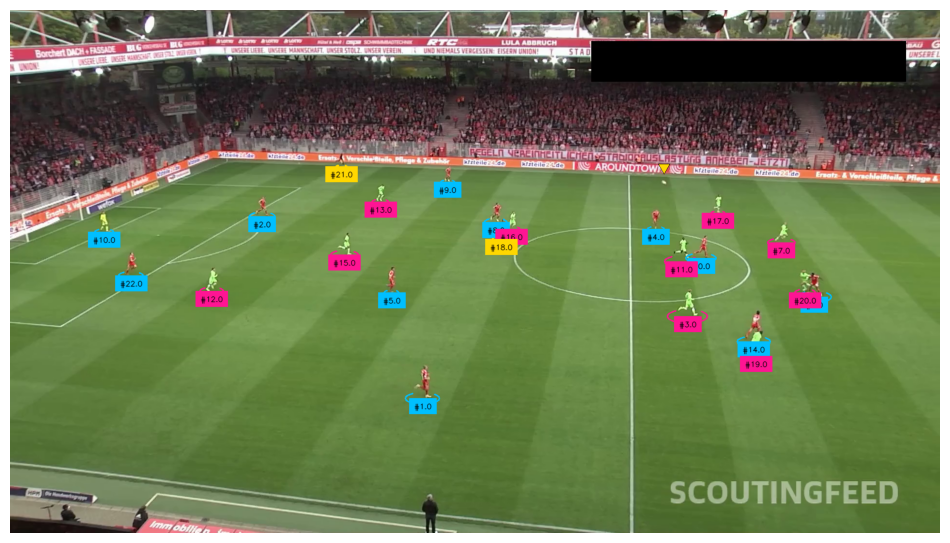

In [27]:
import supervision as sv
from boxmot import BotSort
from pathlib import Path
import torch
import numpy as np

device = torch.device(0)  # Use 'cuda' or CPU as appropriate

# Define class IDs
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# Initialize visual annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# Initialize BotSort tracker with your ReID weights
tracker = BotSort(
    reid_weights=Path('osnet_x0_25_msmt17.pt'),
    device=device,
    half=False
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# Perform detection using your model (using predict here as in your code)
result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

# Process ball detections separately and pad boxes if needed
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# Use non-ball detections for tracking, then apply NMS.
all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

# --- Convert the detections to a NumPy array ---
if all_detections.xyxy.size > 0:
    np_dets = np.hstack((
        all_detections.xyxy,
        all_detections.confidence.reshape(-1, 1),
        all_detections.class_id.reshape(-1, 1)
    ))
else:
    np_dets = np.empty((0, 6))

print("np_dets shape:", np_dets.shape)
print("np_dets contents:", np_dets)

# Update the tracker using the NumPy detections array
updated_tracks = tracker.update(np_dets, frame)
print("updated_tracks shape:", updated_tracks.shape)
print("updated_tracks contents:", updated_tracks)

# Convert the tracker output to a new detections object based on the 8-column format
if updated_tracks.shape[1] == 8:
    new_xyxy = updated_tracks[:, :4]
    new_confidence = updated_tracks[:, 5]
    new_class_id = updated_tracks[:, 6]
    new_tracker_id = updated_tracks[:, 7]
elif updated_tracks.shape[1] == 7:
    new_xyxy = updated_tracks[:, :4]
    new_confidence = updated_tracks[:, 4]
    new_class_id = updated_tracks[:, 5]
    new_tracker_id = updated_tracks[:, 6]
else:
    raise ValueError("Unexpected number of columns from tracker output")

all_detections_updated = sv.Detections(
    xyxy=new_xyxy,
    confidence=new_confidence,
    class_id=new_class_id,
    tracker_id=new_tracker_id
)

# Continue with your post-processing (filtering, annotating, etc.)
goalkeepers_detections = all_detections_updated[all_detections_updated.class_id == GOALKEEPER_ID]
players_detections     = all_detections_updated[all_detections_updated.class_id == PLAYER_ID]
referees_detections    = all_detections_updated[all_detections_updated.class_id == REFEREE_ID]

# Crop and classify players if needed
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

# Resolve goalkeeper teams based on players' classification
goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

# Adjust referee IDs
referees_detections.class_id -= 1

# Merge the detections for final visualization
all_detections_final = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections
])

# Prepare labels from tracker IDs
labels = [f"#{tracker_id}" for tracker_id in all_detections_final.tracker_id]
all_detections_final.class_id = all_detections_final.class_id.astype(int)

# Annotate the frame
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections_final)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections_final, labels=labels)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

sv.plot_image(annotated_frame)


### Tracking with ByteTrack

In [ ]:
import supervision as sv
from tqdm import tqdm
import numpy as np
from boxmot import BotSort
import cv2
from pathlib import Path
import torch

# ----- Configuration and Annotators -----
SOURCE_VIDEO_PATH = "app/test_data/raw/sr2.mp4"
OUTPUT_VIDEO_PATH = "capitano_masr.mp4"
device = torch.device(0)  # Use 'cuda' if you have a GPU

# Class IDs (as used in your training)
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
# (Assuming that sv.StrongSORT is available and provides an update(frame) method.)
tracker = sv.ByteTrack()
tracker.reset()

# ----- INITIAL DETECTION AND CLASS ASSIGNMENT ON FIRST FRAME -----
# Create a generator for frames (stride=1 for the first frame)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=1)
first_frame = next(frame_generator)
height, width = first_frame.shape[:2]
fps = 30  # Set this to the desired frames per second


# Initialize the OpenCV video writer for saving the annotated video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

def process_frame(frame):
    # Run the detection model on the first frame using your local pretrained weights.
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    # Separate ball detections and pad their boxes.
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # For all other detections, apply non-maximum suppression.
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

    # Process player detections with your team classifier.
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    # Process goalkeeper detections using the helper function.
    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    if len(goalkeepers_detections) > 0:
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

    # Adjust referee detections.
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
    referees_detections.class_id -= 1

    # Merge the detections (players, goalkeepers, referees) for tracker initialization.
    initial_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections
    ])

    # ----- INITIALIZE THE STRONGSORT TRACKER -----
    initial_detections = tracker.update_with_detections(detections=initial_detections)

    # Annotate the first frame.
    labels = [f"#{tid}" for tid in initial_detections.tracker_id]

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=initial_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=initial_detections, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    return annotated_frame

# Process the first frame and write it to the video file
total_frames = fps * 20  # Process 10 seconds of video
annotated_first_frame = process_frame(first_frame)
video_writer.write(annotated_first_frame)

# Using tqdm to show progress for the remaining frames
with tqdm(total=total_frames - 1, desc="Processing frames") as pbar:
    for _ in range(total_frames - 1):
        try:
            frame = next(frame_generator)
        except StopIteration:
            break  # video ended before 10 seconds
        annotated_frame = process_frame(frame)
        video_writer.write(annotated_frame)
        pbar.update(1)

# Finalize the video file
video_writer.release()

2025-04-08 13:37:56.184 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.5 🚀 Python-3.11.11 torch-2.5.1+cu121
CUDA:0 (NVIDIA L4, 22478MiB)
2025-04-08 13:37:56.226 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from osnet_x0_25_msmt17.pt


NameError: name 'PLAYER_DETECTION_MODEL' is not defined

### Tracking with BotSort

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings for clarity

import boxmot
import supervision as sv
from tqdm import tqdm
import numpy as np
from boxmot import BotSort, boosttrack
import cv2
from pathlib import Path
import torch

# ----- Configuration and Annotators -----
SOURCE_VIDEO_PATH = "app/test_data/raw/0bfacc_0.mp4"
OUTPUT_VIDEO_PATH = "0bfacc_0_bottrack.mp4"
device = torch.device(0)  # Change to 'cuda' if you have a GPU

# Define class IDs as used during detection/training
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# Initialize BotSort tracker with ReID weights
tracker = BotSort(
    reid_weights=Path('clip_market1501.pt'),
    device=device,
    half=False,
    with_reid=True,
)

# Create a generator for video frames (stride=1 for every frame)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=1)
first_frame = next(frame_generator)

if first_frame is None or first_frame.size == 0:
    raise ValueError("First frame is empty. Please check the video file.")

height, width = first_frame.shape[:2]
fps = 30  # Adjust FPS as needed

# Initialize video writer using OpenCV
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))


def process_frame(frame):
    """
    Process a single video frame: detection, tracking, reID-based classification,
    and annotation. Returns an annotated frame.
    """
    # Verify that frame is nonempty
    if frame is None or frame.size == 0:
        return None

    # --- Inference: Detection with your model ---
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    # --- Process ball detections separately ---
    ball_detections = detections[detections.class_id == BALL_ID]
    if ball_detections.xyxy.size > 0:
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # --- Use non-ball detections for tracking ---
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

    # --- Convert detections to NumPy array (shape: [N,6]) ---
    if all_detections.xyxy.size > 0:
        np_dets = np.hstack((
            all_detections.xyxy,
            all_detections.confidence.reshape(-1, 1),
            all_detections.class_id.reshape(-1, 1)
        ))
    else:
        np_dets = np.empty((0, 6))

    # --- Update tracker ---
    updated_tracks = tracker.update(np_dets, frame)

    # --- Convert updated tracker output to detections object ---
    # Expected format: either 8 columns -> [x1, y1, x2, y2, extra, confidence, class_id, tracker_id]
    if updated_tracks.shape[1] == 8:
        new_xyxy = updated_tracks[:, :4]
        new_confidence = updated_tracks[:, 5]
        new_class_id = updated_tracks[:, 6]
        new_tracker_id = updated_tracks[:, 7]
    elif updated_tracks.shape[1] == 7:
        new_xyxy = updated_tracks[:, :4]
        new_confidence = updated_tracks[:, 4]
        new_class_id = updated_tracks[:, 5]
        new_tracker_id = updated_tracks[:, 6]
    else:
        raise ValueError("Unexpected number of columns from tracker output")

    all_detections_updated = sv.Detections(
        xyxy=new_xyxy,
        confidence=new_confidence,
        class_id=new_class_id,
        tracker_id=new_tracker_id
    )

    # --- Post-processing: Filter detections by class ---
    goalkeepers_detections = all_detections_updated[all_detections_updated.class_id == GOALKEEPER_ID]
    players_detections = all_detections_updated[all_detections_updated.class_id == PLAYER_ID]
    referees_detections = all_detections_updated[all_detections_updated.class_id == REFEREE_ID]

    # --- Ensure safe cropping: clip bounding boxes within frame bounds ---
    def safe_crop(image, box):
        x1, y1, x2, y2 = box.astype(int)
        x1 = np.clip(x1, 0, width)
        y1 = np.clip(y1, 0, height)
        x2 = np.clip(x2, 0, width)
        y2 = np.clip(y2, 0, height)
        if (x2 - x1) <= 0 or (y2 - y1) <= 0:
            return None
        return sv.crop_image(image, np.array([x1, y1, x2, y2]))

    players_crops = []
    for box in players_detections.xyxy:
        crop = safe_crop(frame, box)
        if crop is not None and crop.size > 0:
            players_crops.append(crop)
        else:
            # Use a dummy image if crop is empty to avoid crashing the classifier
            players_crops.append(np.zeros((64, 64, 3), dtype=np.uint8))

    # --- ReID/Team Classification ---
    # team_classifier must be defined (e.g., a pre-trained classifier for team identification)
    players_detections.class_id = team_classifier.predict(players_crops)

    # Resolve goalkeeper teams using the players detections
    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

    # Adjust referee IDs if necessary
    referees_detections.class_id = referees_detections.class_id - 1

    # Merge detections for visualization
    all_detections_final = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections
    ])

    # Prepare labels from tracker IDs
    labels = [f"#{tracker_id}" for tracker_id in all_detections_final.tracker_id]
    all_detections_final.class_id = all_detections_final.class_id.astype(int)

    # --- Annotate frame ---
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections_final)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections_final, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    return annotated_frame


# ----- Process Video Frames -----
total_frames = fps * 30  # Process 20 seconds of video; adjust if necessary

# Process and write first frame
annotated_first_frame = process_frame(first_frame)
if annotated_first_frame is not None:
    video_writer.write(annotated_first_frame)
else:
    print("First frame processing returned None.")

# Process the remaining frames using tqdm for progress display
with tqdm(total=total_frames - 1, desc="Processing frames") as pbar:
    for _ in range(total_frames - 1):
        try:
            frame = next(frame_generator)
        except StopIteration:
            break  # End of video reached
        if frame is None or frame.size == 0:
            print("Empty frame encountered, skipping.")
            continue
        try:
            annotated_frame = process_frame(frame)
        except Exception as e:
            print(f"Error processing frame: {e}")
            continue
        if annotated_frame is not None:
            video_writer.write(annotated_frame)
        else:
            print("Annotated frame is None, skipping.")
        pbar.update(1)

video_writer.release()

2025-04-09 11:51:23.623 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.5 🚀 Python-3.11.11 torch-2.5.1+cu121
CUDA:0 (NVIDIA L4, 22478MiB)
Downloading...
From (original): https://drive.google.com/uc?id=1GnyAVeNOg3Yug1KBBWMKKbT2x43O5Ch7
From (redirected): https://drive.google.com/uc?id=1GnyAVeNOg3Yug1KBBWMKKbT2x43O5Ch7&confirm=t&uuid=4c942f04-12c4-4e7f-ac4f-8a7b8c9cea7d
To: /home/ubuntu/projects/sure-football-analysis/clip_market1501.pt
100%|██████████| 507M/507M [00:06<00:00, 79.0MB/s] 
100%|████████████████████████████████████████| 351M/351M [00:02<00:00, 152MiB/s]


Resized position embedding: %s to %s torch.Size([197, 768]) torch.Size([129, 768])
Position embedding resize to height:16 width: 8


2025-04-09 11:51:38.274 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from clip_market1501.pt



0: 1280x1280 20 players, 3 referees, 65.8ms
Speed: 10.9ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.67it/s]
Processing frames:   0%|          | 0/899 [00:00<?, ?it/s]


0: 1280x1280 20 players, 3 referees, 66.8ms
Speed: 9.6ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.91it/s]
Processing frames:   0%|          | 1/899 [00:00<04:39,  3.21it/s]


0: 1280x1280 20 players, 3 referees, 66.5ms
Speed: 6.2ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.70it/s]
Processing frames:   0%|          | 2/899 [00:00<05:02,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 66.3ms
Speed: 6.3ms preprocess, 66.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   0%|          | 3/899 [00:00<04:52,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 66.7ms
Speed: 10.8ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.70it/s]
Processing frames:   0%|          | 4/899 [00:01<05:03,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.8ms
Speed: 9.3ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:   1%|          | 5/899 [00:01<05:00,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 66.1ms
Speed: 6.1ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:   1%|          | 6/899 [00:01<04:52,  3.05it/s]


0: 1280x1280 22 players, 3 referees, 66.4ms
Speed: 6.3ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   1%|          | 7/899 [00:02<04:59,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 66.3ms
Speed: 10.8ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:   1%|          | 8/899 [00:02<05:06,  2.91it/s]


0: 1280x1280 19 players, 3 referees, 66.5ms
Speed: 6.3ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.91it/s]
Processing frames:   1%|          | 9/899 [00:03<05:07,  2.89it/s]


0: 1280x1280 18 players, 4 referees, 66.7ms
Speed: 6.1ms preprocess, 66.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.41it/s]
Processing frames:   1%|          | 10/899 [00:03<05:05,  2.91it/s]


0: 1280x1280 18 players, 3 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.52it/s]
Processing frames:   1%|          | 11/899 [00:03<04:51,  3.05it/s]


0: 1280x1280 18 players, 3 referees, 66.5ms
Speed: 10.9ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.49it/s]
Processing frames:   1%|▏         | 12/899 [00:03<04:46,  3.09it/s]


0: 1280x1280 19 players, 3 referees, 66.1ms
Speed: 6.3ms preprocess, 66.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.70it/s]
Processing frames:   1%|▏         | 13/899 [00:04<04:42,  3.14it/s]


0: 1280x1280 20 players, 3 referees, 66.7ms
Speed: 6.1ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:   2%|▏         | 14/899 [00:04<04:40,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.2ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]
Processing frames:   2%|▏         | 15/899 [00:04<04:38,  3.17it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   2%|▏         | 16/899 [00:05<04:36,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.2ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:   2%|▏         | 17/899 [00:05<04:38,  3.16it/s]


0: 1280x1280 20 players, 3 referees, 66.8ms
Speed: 6.1ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.64it/s]
Processing frames:   2%|▏         | 18/899 [00:05<04:36,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.2ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:   2%|▏         | 19/899 [00:06<04:35,  3.20it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.2ms
Speed: 10.9ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   2%|▏         | 20/899 [00:06<04:35,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.4ms
Speed: 8.7ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.55it/s]
Processing frames:   2%|▏         | 21/899 [00:06<04:38,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 7.4ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   2%|▏         | 22/899 [00:07<04:38,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.1ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.75it/s]
Processing frames:   3%|▎         | 23/899 [00:07<04:35,  3.18it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.1ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   3%|▎         | 24/899 [00:07<04:34,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.9ms
Speed: 6.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   3%|▎         | 25/899 [00:08<04:35,  3.18it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.1ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   3%|▎         | 26/899 [00:08<04:34,  3.18it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.8ms
Speed: 8.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:   3%|▎         | 27/899 [00:08<04:34,  3.18it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.3ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   3%|▎         | 28/899 [00:09<04:34,  3.17it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.8ms
Speed: 6.3ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   3%|▎         | 29/899 [00:09<04:33,  3.18it/s]


0: 1280x1280 20 players, 3 referees, 66.4ms
Speed: 6.0ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:   3%|▎         | 30/899 [00:09<04:32,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.4ms
Speed: 6.2ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]
Processing frames:   3%|▎         | 31/899 [00:09<04:31,  3.19it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.3ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   4%|▎         | 32/899 [00:10<04:42,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 9.2ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   4%|▎         | 33/899 [00:10<04:39,  3.10it/s]


0: 1280x1280 2 balls, 20 players, 3 referees, 66.7ms
Speed: 6.0ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   4%|▍         | 34/899 [00:10<04:37,  3.12it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 8.4ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   4%|▍         | 35/899 [00:11<04:35,  3.13it/s]


0: 1280x1280 21 players, 3 referees, 66.6ms
Speed: 10.8ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:   4%|▍         | 36/899 [00:11<04:36,  3.12it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.2ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:   4%|▍         | 37/899 [00:11<04:44,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 8.5ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:   4%|▍         | 38/899 [00:12<04:46,  3.01it/s]


0: 1280x1280 21 players, 4 referees, 66.2ms
Speed: 6.7ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]
Processing frames:   4%|▍         | 39/899 [00:12<04:44,  3.03it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.61it/s]
Processing frames:   4%|▍         | 40/899 [00:12<04:42,  3.04it/s]


0: 1280x1280 21 players, 3 referees, 66.7ms
Speed: 6.3ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.55it/s]
Processing frames:   5%|▍         | 41/899 [00:13<04:38,  3.08it/s]


0: 1280x1280 21 players, 3 referees, 66.9ms
Speed: 6.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.63it/s]
Processing frames:   5%|▍         | 42/899 [00:13<04:35,  3.12it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.5ms
Speed: 6.1ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.61it/s]
Processing frames:   5%|▍         | 43/899 [00:13<04:43,  3.02it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.65it/s]
Processing frames:   5%|▍         | 44/899 [00:14<04:50,  2.95it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.6ms
Speed: 6.1ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   5%|▌         | 45/899 [00:14<04:54,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.4ms
Speed: 6.6ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   5%|▌         | 46/899 [00:14<04:54,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.4ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   5%|▌         | 47/899 [00:15<04:56,  2.87it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.97it/s]
Processing frames:   5%|▌         | 48/899 [00:15<04:46,  2.97it/s]


0: 1280x1280 21 players, 4 referees, 66.5ms
Speed: 6.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.68it/s]
Processing frames:   5%|▌         | 49/899 [00:15<04:43,  3.00it/s]


0: 1280x1280 20 players, 4 referees, 67.4ms
Speed: 6.4ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.73it/s]
Processing frames:   6%|▌         | 50/899 [00:16<04:40,  3.03it/s]


0: 1280x1280 20 players, 4 referees, 66.6ms
Speed: 8.3ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.78it/s]
Processing frames:   6%|▌         | 51/899 [00:16<04:42,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.65it/s]
Processing frames:   6%|▌         | 52/899 [00:16<04:35,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 66.7ms
Speed: 6.1ms preprocess, 66.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.70it/s]
Processing frames:   6%|▌         | 53/899 [00:17<04:31,  3.12it/s]


0: 1280x1280 20 players, 3 referees, 66.5ms
Speed: 8.6ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.65it/s]
Processing frames:   6%|▌         | 54/899 [00:17<04:28,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 8.7ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:   6%|▌         | 55/899 [00:17<04:26,  3.16it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.5ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.71it/s]
Processing frames:   6%|▌         | 56/899 [00:18<04:35,  3.06it/s]


0: 1280x1280 19 players, 4 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.75it/s]
Processing frames:   6%|▋         | 57/899 [00:18<04:30,  3.12it/s]


0: 1280x1280 20 players, 3 referees, 66.4ms
Speed: 6.2ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.62it/s]
Processing frames:   6%|▋         | 58/899 [00:18<04:37,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:   7%|▋         | 59/899 [00:19<04:33,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.2ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:   7%|▋         | 60/899 [00:19<04:31,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.4ms
Speed: 9.4ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   7%|▋         | 61/899 [00:19<04:40,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 8.7ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:   7%|▋         | 62/899 [00:20<04:36,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.2ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:   7%|▋         | 63/899 [00:20<04:40,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.8ms
Speed: 6.1ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:   7%|▋         | 64/899 [00:20<04:46,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.4ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.55it/s]
Processing frames:   7%|▋         | 65/899 [00:21<04:49,  2.88it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.7ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]
Processing frames:   7%|▋         | 66/899 [00:21<04:51,  2.86it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.9ms
Speed: 7.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.55it/s]
Processing frames:   7%|▋         | 67/899 [00:21<04:53,  2.83it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.2ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:   8%|▊         | 68/899 [00:22<04:54,  2.82it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 9.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:   8%|▊         | 69/899 [00:22<04:46,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 8.3ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:   8%|▊         | 70/899 [00:22<04:39,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.1ms preprocess, 66.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   8%|▊         | 71/899 [00:23<04:41,  2.94it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   8%|▊         | 72/899 [00:23<04:45,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:   8%|▊         | 73/899 [00:23<04:38,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 67.2ms
Speed: 8.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:   8%|▊         | 74/899 [00:24<04:43,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 66.9ms
Speed: 7.7ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   8%|▊         | 75/899 [00:24<04:36,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   8%|▊         | 76/899 [00:25<04:45,  2.88it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 10.2ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:   9%|▊         | 77/899 [00:25<04:49,  2.84it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 9.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:   9%|▊         | 78/899 [00:25<04:41,  2.92it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.2ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.61it/s]
Processing frames:   9%|▉         | 79/899 [00:26<04:33,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 10.8ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   9%|▉         | 80/899 [00:26<04:32,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.0ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:   9%|▉         | 81/899 [00:26<04:27,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:   9%|▉         | 82/899 [00:26<04:24,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.6ms
Speed: 6.1ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:   9%|▉         | 83/899 [00:27<04:32,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.9ms
Speed: 6.1ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:   9%|▉         | 84/899 [00:27<04:27,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:   9%|▉         | 85/899 [00:27<04:24,  3.08it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 9.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  10%|▉         | 86/899 [00:28<04:33,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 9.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.64it/s]
Processing frames:  10%|▉         | 87/899 [00:28<04:31,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.7ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:  10%|▉         | 88/899 [00:28<04:27,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 10.2ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.50it/s]
Processing frames:  10%|▉         | 89/899 [00:29<04:26,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:  10%|█         | 90/899 [00:29<04:23,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.5ms
Speed: 6.3ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.52it/s]
Processing frames:  10%|█         | 91/899 [00:29<04:31,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  10%|█         | 92/899 [00:30<04:27,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 10.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.50it/s]
Processing frames:  10%|█         | 93/899 [00:30<04:30,  2.98it/s]


0: 1280x1280 21 players, 3 referees, 66.9ms
Speed: 9.4ms preprocess, 66.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]
Processing frames:  10%|█         | 94/899 [00:30<04:29,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 66.6ms
Speed: 6.1ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:  11%|█         | 95/899 [00:31<04:24,  3.04it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 6.3ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]
Processing frames:  11%|█         | 96/899 [00:31<04:31,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.58it/s]
Processing frames:  11%|█         | 97/899 [00:32<04:36,  2.90it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  11%|█         | 98/899 [00:32<04:29,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]
Processing frames:  11%|█         | 99/899 [00:32<04:34,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 10.9ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]
Processing frames:  11%|█         | 100/899 [00:33<04:38,  2.86it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  11%|█         | 101/899 [00:33<04:30,  2.94it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 9.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:  11%|█▏        | 102/899 [00:33<04:35,  2.89it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  11%|█▏        | 103/899 [00:34<04:29,  2.96it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 66.9ms
Speed: 10.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]
Processing frames:  12%|█▏        | 104/899 [00:34<04:34,  2.89it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 10.0ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:  12%|█▏        | 105/899 [00:34<04:28,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 9.5ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  12%|█▏        | 106/899 [00:35<04:24,  3.00it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.7ms
Speed: 6.3ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]
Processing frames:  12%|█▏        | 107/899 [00:35<04:30,  2.93it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 66.7ms
Speed: 6.1ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:  12%|█▏        | 108/899 [00:35<04:23,  3.00it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  12%|█▏        | 109/899 [00:36<04:19,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  12%|█▏        | 110/899 [00:36<04:17,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  12%|█▏        | 111/899 [00:36<04:16,  3.07it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.9ms
Speed: 6.1ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  12%|█▏        | 112/899 [00:37<04:13,  3.10it/s]


0: 1280x1280 2 balls, 21 players, 2 referees, 67.3ms
Speed: 9.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  13%|█▎        | 113/899 [00:37<04:19,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.7ms
Speed: 6.1ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.09it/s]
Processing frames:  13%|█▎        | 114/899 [00:37<04:14,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:  13%|█▎        | 115/899 [00:38<04:22,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 10.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  13%|█▎        | 116/899 [00:38<04:19,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.25it/s]
Processing frames:  13%|█▎        | 117/899 [00:38<04:23,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.65it/s]
Processing frames:  13%|█▎        | 118/899 [00:39<04:16,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  13%|█▎        | 119/899 [00:39<04:13,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 67.2ms
Speed: 10.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  13%|█▎        | 120/899 [00:39<04:14,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.0ms
Speed: 6.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  13%|█▎        | 121/899 [00:39<04:11,  3.10it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  14%|█▎        | 122/899 [00:40<04:18,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  14%|█▎        | 123/899 [00:40<04:13,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 10.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.50it/s]
Processing frames:  14%|█▍        | 124/899 [00:41<04:20,  2.97it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.3ms
Speed: 9.7ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  14%|█▍        | 125/899 [00:41<04:16,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 8.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  14%|█▍        | 126/899 [00:41<04:13,  3.05it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 8.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  14%|█▍        | 127/899 [00:42<04:21,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  14%|█▍        | 128/899 [00:42<04:26,  2.89it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 9.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  14%|█▍        | 129/899 [00:42<04:30,  2.85it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  14%|█▍        | 130/899 [00:43<04:21,  2.94it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.5ms
Speed: 6.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  15%|█▍        | 131/899 [00:43<04:19,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  15%|█▍        | 132/899 [00:43<04:14,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 66.8ms
Speed: 9.8ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  15%|█▍        | 133/899 [00:44<04:21,  2.93it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 8.5ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  15%|█▍        | 134/899 [00:44<04:16,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  15%|█▌        | 135/899 [00:44<04:13,  3.02it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  15%|█▌        | 136/899 [00:45<04:11,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  15%|█▌        | 137/899 [00:45<04:18,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 8.9ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  15%|█▌        | 138/899 [00:45<04:13,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  15%|█▌        | 139/899 [00:46<04:10,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 6.3ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  16%|█▌        | 140/899 [00:46<04:16,  2.96it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 9.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  16%|█▌        | 141/899 [00:46<04:12,  3.00it/s]


0: 1280x1280 20 players, 4 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  16%|█▌        | 142/899 [00:47<04:08,  3.04it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 8.4ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  16%|█▌        | 143/899 [00:47<04:07,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  16%|█▌        | 144/899 [00:47<04:14,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 67.2ms
Speed: 9.7ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  16%|█▌        | 145/899 [00:48<04:18,  2.92it/s]


0: 1280x1280 20 players, 3 referees, 66.4ms
Speed: 13.0ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  16%|█▌        | 146/899 [00:48<04:24,  2.85it/s]


0: 1280x1280 22 players, 3 referees, 66.9ms
Speed: 8.6ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  16%|█▋        | 147/899 [00:48<04:20,  2.89it/s]


0: 1280x1280 22 players, 4 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  16%|█▋        | 148/899 [00:49<04:12,  2.97it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  17%|█▋        | 149/899 [00:49<04:08,  3.02it/s]


0: 1280x1280 22 players, 3 referees, 67.1ms
Speed: 7.9ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  17%|█▋        | 150/899 [00:49<04:06,  3.03it/s]


0: 1280x1280 22 players, 3 referees, 67.4ms
Speed: 6.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  17%|█▋        | 151/899 [00:50<04:18,  2.90it/s]


0: 1280x1280 22 players, 3 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.73it/s]
Processing frames:  17%|█▋        | 152/899 [00:50<04:16,  2.91it/s]


0: 1280x1280 22 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]
Processing frames:  17%|█▋        | 153/899 [00:50<04:15,  2.92it/s]


0: 1280x1280 22 players, 3 referees, 67.6ms
Speed: 7.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.78it/s]
Processing frames:  17%|█▋        | 154/899 [00:51<04:23,  2.83it/s]


0: 1280x1280 22 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]
Processing frames:  17%|█▋        | 155/899 [00:51<04:16,  2.90it/s]


0: 1280x1280 22 players, 2 referees, 67.5ms
Speed: 10.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]
Processing frames:  17%|█▋        | 156/899 [00:51<04:22,  2.83it/s]


0: 1280x1280 21 players, 4 referees, 67.4ms
Speed: 8.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]
Processing frames:  17%|█▋        | 157/899 [00:52<04:18,  2.87it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.77it/s]
Processing frames:  18%|█▊        | 158/899 [00:52<04:23,  2.81it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]
Processing frames:  18%|█▊        | 159/899 [00:52<04:27,  2.76it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.5ms
Speed: 10.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  18%|█▊        | 160/899 [00:53<04:22,  2.82it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.0ms
Speed: 6.3ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  18%|█▊        | 161/899 [00:53<04:25,  2.78it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 8.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  18%|█▊        | 162/899 [00:54<04:21,  2.82it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  18%|█▊        | 163/899 [00:54<04:20,  2.83it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]
Processing frames:  18%|█▊        | 164/899 [00:54<04:16,  2.87it/s]


0: 1280x1280 21 players, 4 referees, 66.9ms
Speed: 6.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.75it/s]
Processing frames:  18%|█▊        | 165/899 [00:55<04:11,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  18%|█▊        | 166/899 [00:55<04:10,  2.92it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.64it/s]
Processing frames:  19%|█▊        | 167/899 [00:55<04:08,  2.94it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.76it/s]
Processing frames:  19%|█▊        | 168/899 [00:56<04:07,  2.96it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.23it/s]
Processing frames:  19%|█▉        | 169/899 [00:56<04:22,  2.78it/s]


0: 1280x1280 21 players, 4 referees, 67.1ms
Speed: 7.6ms preprocess, 67.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.51it/s]
Processing frames:  19%|█▉        | 170/899 [00:56<04:18,  2.82it/s]


0: 1280x1280 21 players, 4 referees, 67.4ms
Speed: 7.5ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.70it/s]
Processing frames:  19%|█▉        | 171/899 [00:57<04:14,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  19%|█▉        | 172/899 [00:57<04:10,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 66.9ms
Speed: 6.2ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.64it/s]
Processing frames:  19%|█▉        | 173/899 [00:57<04:06,  2.95it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.70it/s]
Processing frames:  19%|█▉        | 174/899 [00:58<04:03,  2.97it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  19%|█▉        | 175/899 [00:58<04:09,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 9.6ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]
Processing frames:  20%|█▉        | 176/899 [00:58<04:05,  2.94it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 7.6ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.77it/s]
Processing frames:  20%|█▉        | 177/899 [00:59<04:12,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  20%|█▉        | 178/899 [00:59<04:07,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.5ms
Speed: 7.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.77it/s]
Processing frames:  20%|█▉        | 179/899 [00:59<04:03,  2.95it/s]


0: 1280x1280 21 players, 4 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]
Processing frames:  20%|██        | 180/899 [01:00<04:03,  2.95it/s]


0: 1280x1280 21 players, 4 referees, 67.5ms
Speed: 8.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  20%|██        | 181/899 [01:00<04:03,  2.95it/s]


0: 1280x1280 22 players, 4 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  20%|██        | 182/899 [01:00<04:01,  2.97it/s]


0: 1280x1280 22 players, 5 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  20%|██        | 183/899 [01:01<04:00,  2.98it/s]


0: 1280x1280 22 players, 4 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  20%|██        | 184/899 [01:01<03:59,  2.98it/s]


0: 1280x1280 22 players, 4 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  21%|██        | 185/899 [01:01<03:58,  2.99it/s]


0: 1280x1280 22 players, 3 referees, 67.8ms
Speed: 7.7ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.70it/s]
Processing frames:  21%|██        | 186/899 [01:02<03:58,  2.99it/s]


0: 1280x1280 22 players, 4 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  21%|██        | 187/899 [01:02<03:58,  2.99it/s]


0: 1280x1280 21 players, 4 referees, 67.9ms
Speed: 10.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  21%|██        | 188/899 [01:02<03:59,  2.97it/s]


0: 1280x1280 21 players, 4 referees, 68.0ms
Speed: 9.5ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  21%|██        | 189/899 [01:03<04:08,  2.86it/s]


0: 1280x1280 22 players, 4 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.75it/s]
Processing frames:  21%|██        | 190/899 [01:03<04:13,  2.79it/s]


0: 1280x1280 22 players, 5 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.65it/s]
Processing frames:  21%|██        | 191/899 [01:03<04:07,  2.86it/s]


0: 1280x1280 1 ball, 22 players, 4 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  21%|██▏       | 192/899 [01:04<04:01,  2.93it/s]


0: 1280x1280 22 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]
Processing frames:  21%|██▏       | 193/899 [01:04<04:00,  2.94it/s]


0: 1280x1280 22 players, 3 referees, 67.6ms
Speed: 8.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]
Processing frames:  22%|██▏       | 194/899 [01:04<03:59,  2.95it/s]


0: 1280x1280 22 players, 4 referees, 67.1ms
Speed: 8.3ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  22%|██▏       | 195/899 [01:05<04:06,  2.85it/s]


0: 1280x1280 22 players, 4 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  22%|██▏       | 196/899 [01:05<04:02,  2.90it/s]


0: 1280x1280 22 players, 4 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  22%|██▏       | 197/899 [01:06<04:00,  2.92it/s]


0: 1280x1280 22 players, 4 referees, 67.5ms
Speed: 8.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  22%|██▏       | 198/899 [01:06<04:08,  2.82it/s]


0: 1280x1280 1 ball, 21 players, 5 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  22%|██▏       | 199/899 [01:06<04:10,  2.80it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.70it/s]
Processing frames:  22%|██▏       | 200/899 [01:07<04:00,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  22%|██▏       | 201/899 [01:07<04:01,  2.89it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 11.3ms preprocess, 67.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  22%|██▏       | 202/899 [01:07<03:59,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.0ms
Speed: 6.3ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  23%|██▎       | 203/899 [01:08<03:53,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  23%|██▎       | 204/899 [01:08<03:53,  2.97it/s]


0: 1280x1280 22 players, 3 referees, 66.8ms
Speed: 8.9ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  23%|██▎       | 205/899 [01:08<03:58,  2.91it/s]


0: 1280x1280 22 players, 3 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  23%|██▎       | 206/899 [01:09<03:53,  2.96it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 8.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  23%|██▎       | 207/899 [01:09<03:49,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  23%|██▎       | 208/899 [01:09<03:46,  3.05it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  23%|██▎       | 209/899 [01:10<03:44,  3.07it/s]


0: 1280x1280 21 players, 3 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  23%|██▎       | 210/899 [01:10<03:51,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.96it/s]
Processing frames:  23%|██▎       | 211/899 [01:10<03:45,  3.05it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  24%|██▎       | 212/899 [01:11<03:43,  3.08it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  24%|██▎       | 213/899 [01:11<03:41,  3.10it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.20it/s]
Processing frames:  24%|██▍       | 214/899 [01:11<03:49,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  24%|██▍       | 215/899 [01:12<03:46,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 10.8ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  24%|██▍       | 216/899 [01:12<03:44,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 8.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  24%|██▍       | 217/899 [01:12<03:43,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  24%|██▍       | 218/899 [01:12<03:40,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 7.4ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  24%|██▍       | 219/899 [01:13<03:47,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.12it/s]
Processing frames:  24%|██▍       | 220/899 [01:13<03:44,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  25%|██▍       | 221/899 [01:13<03:41,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  25%|██▍       | 222/899 [01:14<03:38,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.6ms
Speed: 6.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  25%|██▍       | 223/899 [01:14<03:36,  3.12it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  25%|██▍       | 224/899 [01:14<03:35,  3.13it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  25%|██▌       | 225/899 [01:15<03:34,  3.14it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 7.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  25%|██▌       | 226/899 [01:15<03:34,  3.14it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  25%|██▌       | 227/899 [01:15<03:34,  3.13it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 10.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  25%|██▌       | 228/899 [01:16<03:34,  3.12it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  25%|██▌       | 229/899 [01:16<03:32,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  26%|██▌       | 230/899 [01:16<03:31,  3.16it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  26%|██▌       | 231/899 [01:17<03:32,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 10.7ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  26%|██▌       | 232/899 [01:17<03:33,  3.13it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 8.5ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  26%|██▌       | 233/899 [01:17<03:33,  3.12it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 7.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  26%|██▌       | 234/899 [01:18<03:32,  3.12it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 7.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  26%|██▌       | 235/899 [01:18<03:32,  3.13it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 10.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  26%|██▋       | 236/899 [01:18<03:32,  3.12it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  26%|██▋       | 237/899 [01:19<03:31,  3.13it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  26%|██▋       | 238/899 [01:19<03:31,  3.12it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 8.4ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.64it/s]
Processing frames:  27%|██▋       | 239/899 [01:19<03:35,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.70it/s]
Processing frames:  27%|██▋       | 240/899 [01:20<03:38,  3.01it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  27%|██▋       | 241/899 [01:20<03:36,  3.04it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  27%|██▋       | 242/899 [01:20<03:35,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 8.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  27%|██▋       | 243/899 [01:21<03:33,  3.07it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 67.5ms
Speed: 8.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  27%|██▋       | 244/899 [01:21<03:34,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  27%|██▋       | 245/899 [01:21<03:36,  3.02it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 10.8ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.65it/s]
Processing frames:  27%|██▋       | 246/899 [01:22<03:46,  2.88it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  27%|██▋       | 247/899 [01:22<03:44,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  28%|██▊       | 248/899 [01:22<03:42,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.1ms
Speed: 8.3ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  28%|██▊       | 249/899 [01:23<03:44,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 10.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  28%|██▊       | 250/899 [01:23<03:44,  2.90it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  28%|██▊       | 251/899 [01:23<03:43,  2.90it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 7.6ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  28%|██▊       | 252/899 [01:24<03:42,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 8.4ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  28%|██▊       | 253/899 [01:24<03:41,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 10.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]
Processing frames:  28%|██▊       | 254/899 [01:24<03:40,  2.93it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  28%|██▊       | 255/899 [01:25<03:35,  2.99it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 67.1ms
Speed: 8.3ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  28%|██▊       | 256/899 [01:25<03:33,  3.02it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  29%|██▊       | 257/899 [01:25<03:32,  3.03it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  29%|██▊       | 258/899 [01:26<03:29,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 6.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  29%|██▉       | 259/899 [01:26<03:28,  3.07it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  29%|██▉       | 260/899 [01:26<03:27,  3.08it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.5ms
Speed: 6.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  29%|██▉       | 261/899 [01:27<03:28,  3.05it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 11.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  29%|██▉       | 262/899 [01:27<03:28,  3.06it/s]


0: 1280x1280 22 players, 3 referees, 67.4ms
Speed: 8.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  29%|██▉       | 263/899 [01:27<03:26,  3.07it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  29%|██▉       | 264/899 [01:28<03:26,  3.07it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.0ms
Speed: 7.7ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  29%|██▉       | 265/899 [01:28<03:33,  2.97it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  30%|██▉       | 266/899 [01:28<03:37,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 8.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  30%|██▉       | 267/899 [01:29<03:36,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.8ms
Speed: 8.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.36it/s]
Processing frames:  30%|██▉       | 268/899 [01:29<03:36,  2.92it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.65it/s]
Processing frames:  30%|██▉       | 269/899 [01:29<03:36,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 10.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  30%|███       | 270/899 [01:30<03:43,  2.81it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  30%|███       | 271/899 [01:30<03:39,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.65it/s]
Processing frames:  30%|███       | 272/899 [01:30<03:38,  2.87it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.51it/s]
Processing frames:  30%|███       | 273/899 [01:31<03:36,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]
Processing frames:  30%|███       | 274/899 [01:31<03:42,  2.80it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  31%|███       | 275/899 [01:31<03:39,  2.85it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  31%|███       | 276/899 [01:32<03:37,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 8.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  31%|███       | 277/899 [01:32<03:35,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  31%|███       | 278/899 [01:33<03:34,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  31%|███       | 279/899 [01:33<03:32,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 8.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  31%|███       | 280/899 [01:33<03:40,  2.81it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  31%|███▏      | 281/899 [01:34<03:36,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]
Processing frames:  31%|███▏      | 282/899 [01:34<03:34,  2.88it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 9.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  31%|███▏      | 283/899 [01:34<03:33,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  32%|███▏      | 284/899 [01:35<03:31,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  32%|███▏      | 285/899 [01:35<03:37,  2.82it/s]


0: 1280x1280 22 players, 3 referees, 67.2ms
Speed: 10.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  32%|███▏      | 286/899 [01:35<03:35,  2.85it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 9.3ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  32%|███▏      | 287/899 [01:36<03:33,  2.87it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 8.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  32%|███▏      | 288/899 [01:36<03:31,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 8.4ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  32%|███▏      | 289/899 [01:36<03:29,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 10.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  32%|███▏      | 290/899 [01:37<03:29,  2.90it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 8.4ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  32%|███▏      | 291/899 [01:37<03:28,  2.92it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 8.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  32%|███▏      | 292/899 [01:37<03:27,  2.93it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  33%|███▎      | 293/899 [01:38<03:26,  2.93it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 10.8ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  33%|███▎      | 294/899 [01:38<03:26,  2.92it/s]


0: 1280x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 68.5ms
Speed: 6.3ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  33%|███▎      | 295/899 [01:38<03:33,  2.82it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  33%|███▎      | 296/899 [01:39<03:32,  2.84it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.0ms
Speed: 6.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.48it/s]
Processing frames:  33%|███▎      | 297/899 [01:39<03:30,  2.86it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  33%|███▎      | 298/899 [01:39<03:28,  2.88it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 9.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  33%|███▎      | 299/899 [01:40<03:27,  2.89it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 8.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  33%|███▎      | 300/899 [01:40<03:26,  2.90it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  33%|███▎      | 301/899 [01:40<03:25,  2.92it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  34%|███▎      | 302/899 [01:41<03:22,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  34%|███▎      | 303/899 [01:41<03:19,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 68.3ms
Speed: 8.2ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  34%|███▍      | 304/899 [01:41<03:17,  3.02it/s]


0: 1280x1280 21 players, 3 referees, 68.5ms
Speed: 6.2ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  34%|███▍      | 305/899 [01:42<03:22,  2.93it/s]


0: 1280x1280 21 players, 3 referees, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.49it/s]
Processing frames:  34%|███▍      | 306/899 [01:42<03:22,  2.93it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  34%|███▍      | 307/899 [01:43<03:28,  2.83it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 6.3ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  34%|███▍      | 308/899 [01:43<03:24,  2.89it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 68.1ms
Speed: 8.4ms preprocess, 68.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.43it/s]
Processing frames:  34%|███▍      | 309/899 [01:43<03:30,  2.80it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  34%|███▍      | 310/899 [01:44<03:33,  2.76it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.8ms
Speed: 6.3ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  35%|███▍      | 311/899 [01:44<03:28,  2.82it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 9.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  35%|███▍      | 312/899 [01:44<03:33,  2.75it/s]


0: 1280x1280 21 players, 3 referees, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  35%|███▍      | 313/899 [01:45<03:35,  2.71it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 6.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  35%|███▍      | 314/899 [01:45<03:30,  2.78it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 9.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  35%|███▌      | 315/899 [01:45<03:27,  2.81it/s]


0: 1280x1280 22 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.65it/s]
Processing frames:  35%|███▌      | 316/899 [01:46<03:31,  2.76it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  35%|███▌      | 317/899 [01:46<03:26,  2.82it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]
Processing frames:  35%|███▌      | 318/899 [01:47<03:30,  2.76it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 8.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  35%|███▌      | 319/899 [01:47<03:27,  2.80it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  36%|███▌      | 320/899 [01:47<03:26,  2.81it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 7.4ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  36%|███▌      | 321/899 [01:48<03:30,  2.75it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 6.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.56it/s]
Processing frames:  36%|███▌      | 322/899 [01:48<03:26,  2.80it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  36%|███▌      | 323/899 [01:48<03:22,  2.84it/s]


0: 1280x1280 1 ball, 23 players, 3 referees, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  36%|███▌      | 324/899 [01:49<03:27,  2.77it/s]


0: 1280x1280 1 ball, 23 players, 3 referees, 68.5ms
Speed: 6.2ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  36%|███▌      | 325/899 [01:49<03:23,  2.82it/s]


0: 1280x1280 22 players, 3 referees, 68.1ms
Speed: 6.4ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.64it/s]
Processing frames:  36%|███▋      | 326/899 [01:49<03:20,  2.86it/s]


0: 1280x1280 22 players, 3 referees, 68.5ms
Speed: 7.6ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]
Processing frames:  36%|███▋      | 327/899 [01:50<03:17,  2.90it/s]


0: 1280x1280 22 players, 3 referees, 67.3ms
Speed: 7.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  36%|███▋      | 328/899 [01:50<03:16,  2.91it/s]


0: 1280x1280 22 players, 2 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]
Processing frames:  37%|███▋      | 329/899 [01:50<03:14,  2.93it/s]


0: 1280x1280 22 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  37%|███▋      | 330/899 [01:51<03:12,  2.96it/s]


0: 1280x1280 21 players, 3 referees, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  37%|███▋      | 331/899 [01:51<03:11,  2.96it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.6ms
Speed: 6.1ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  37%|███▋      | 332/899 [01:51<03:10,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  37%|███▋      | 333/899 [01:52<03:09,  2.98it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 10.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  37%|███▋      | 334/899 [01:52<03:10,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 6.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  37%|███▋      | 335/899 [01:52<03:09,  2.98it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 7.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.56it/s]
Processing frames:  37%|███▋      | 336/899 [01:53<03:08,  2.99it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  37%|███▋      | 337/899 [01:53<03:08,  2.98it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 9.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  38%|███▊      | 338/899 [01:53<03:08,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 7.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  38%|███▊      | 339/899 [01:54<03:07,  2.99it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  38%|███▊      | 340/899 [01:54<03:06,  3.00it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]
Processing frames:  38%|███▊      | 341/899 [01:54<03:05,  3.00it/s]


0: 1280x1280 22 players, 2 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  38%|███▊      | 342/899 [01:55<03:05,  3.00it/s]


0: 1280x1280 22 players, 2 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  38%|███▊      | 343/899 [01:55<03:04,  3.01it/s]


0: 1280x1280 22 players, 2 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  38%|███▊      | 344/899 [01:55<03:04,  3.02it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 67.9ms
Speed: 8.5ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  38%|███▊      | 345/899 [01:56<03:03,  3.01it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.50it/s]
Processing frames:  38%|███▊      | 346/899 [01:56<03:03,  3.01it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.8ms
Speed: 6.2ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.56it/s]
Processing frames:  39%|███▊      | 347/899 [01:56<03:04,  2.99it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  39%|███▊      | 348/899 [01:57<03:04,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.5ms
Speed: 9.2ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  39%|███▉      | 349/899 [01:57<03:05,  2.96it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.0ms
Speed: 10.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  39%|███▉      | 350/899 [01:57<03:07,  2.94it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.62it/s]
Processing frames:  39%|███▉      | 351/899 [01:58<03:13,  2.83it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  39%|███▉      | 352/899 [01:58<03:18,  2.76it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  39%|███▉      | 353/899 [01:58<03:14,  2.81it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 10.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.56it/s]
Processing frames:  39%|███▉      | 354/899 [01:59<03:12,  2.84it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.6ms
Speed: 6.2ms preprocess, 68.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  39%|███▉      | 355/899 [01:59<03:10,  2.86it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 8.6ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  40%|███▉      | 356/899 [02:00<03:08,  2.88it/s]


0: 1280x1280 21 players, 3 referees, 68.3ms
Speed: 6.3ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  40%|███▉      | 357/899 [02:00<03:06,  2.90it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  40%|███▉      | 358/899 [02:00<03:11,  2.82it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 10.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  40%|███▉      | 359/899 [02:01<03:16,  2.75it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.52it/s]
Processing frames:  40%|████      | 360/899 [02:01<03:13,  2.79it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 9.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.63it/s]
Processing frames:  40%|████      | 361/899 [02:01<03:17,  2.73it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.56it/s]
Processing frames:  40%|████      | 362/899 [02:02<03:11,  2.80it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]
Processing frames:  40%|████      | 363/899 [02:02<03:09,  2.83it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]
Processing frames:  40%|████      | 364/899 [02:02<03:06,  2.86it/s]


0: 1280x1280 21 players, 2 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.57it/s]
Processing frames:  41%|████      | 365/899 [02:03<03:10,  2.80it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 10.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]
Processing frames:  41%|████      | 366/899 [02:03<03:08,  2.82it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.60it/s]
Processing frames:  41%|████      | 367/899 [02:03<03:05,  2.86it/s]


0: 1280x1280 21 players, 3 referees, 68.4ms
Speed: 9.0ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]
Processing frames:  41%|████      | 368/899 [02:04<03:04,  2.88it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  41%|████      | 369/899 [02:04<02:59,  2.95it/s]


0: 1280x1280 20 players, 4 referees, 67.7ms
Speed: 10.9ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  41%|████      | 370/899 [02:04<02:57,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  41%|████▏     | 371/899 [02:05<02:55,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 68.4ms
Speed: 9.3ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  41%|████▏     | 372/899 [02:05<02:54,  3.02it/s]


0: 1280x1280 20 players, 2 referees, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  41%|████▏     | 373/899 [02:05<02:55,  3.00it/s]


0: 1280x1280 20 players, 2 referees, 67.6ms
Speed: 10.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  42%|████▏     | 374/899 [02:06<02:59,  2.92it/s]


0: 1280x1280 20 players, 2 referees, 68.0ms
Speed: 10.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  42%|████▏     | 375/899 [02:06<03:02,  2.87it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 9.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  42%|████▏     | 376/899 [02:06<02:58,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  42%|████▏     | 377/899 [02:07<02:54,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  42%|████▏     | 378/899 [02:07<02:56,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  42%|████▏     | 379/899 [02:07<02:53,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  42%|████▏     | 380/899 [02:08<02:51,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.3ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  42%|████▏     | 381/899 [02:08<02:55,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 10.8ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  42%|████▏     | 382/899 [02:09<03:00,  2.87it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  43%|████▎     | 383/899 [02:09<02:54,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 9.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  43%|████▎     | 384/899 [02:09<02:58,  2.89it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 9.7ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  43%|████▎     | 385/899 [02:10<02:55,  2.93it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 10.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  43%|████▎     | 386/899 [02:10<02:52,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 10.0ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  43%|████▎     | 387/899 [02:10<02:50,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  43%|████▎     | 388/899 [02:10<02:47,  3.05it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  43%|████▎     | 389/899 [02:11<02:46,  3.06it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 10.9ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  43%|████▎     | 390/899 [02:11<02:51,  2.97it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  43%|████▎     | 391/899 [02:11<02:48,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  44%|████▎     | 392/899 [02:12<02:45,  3.06it/s]


0: 1280x1280 20 players, 2 referees, 68.0ms
Speed: 6.4ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  44%|████▎     | 393/899 [02:12<02:44,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  44%|████▍     | 394/899 [02:12<02:43,  3.10it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 9.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  44%|████▍     | 395/899 [02:13<02:42,  3.11it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  44%|████▍     | 396/899 [02:13<02:40,  3.13it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  44%|████▍     | 397/899 [02:13<02:39,  3.15it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  44%|████▍     | 398/899 [02:14<02:38,  3.16it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 9.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  44%|████▍     | 399/899 [02:14<02:38,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  44%|████▍     | 400/899 [02:14<02:38,  3.14it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  45%|████▍     | 401/899 [02:15<02:38,  3.14it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 10.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  45%|████▍     | 402/899 [02:15<02:41,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  45%|████▍     | 403/899 [02:15<02:41,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  45%|████▍     | 404/899 [02:16<02:41,  3.07it/s]


0: 1280x1280 20 players, 4 referees, 67.7ms
Speed: 7.3ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  45%|████▌     | 405/899 [02:16<02:40,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 7.0ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  45%|████▌     | 406/899 [02:16<02:39,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  45%|████▌     | 407/899 [02:17<02:39,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 7.6ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  45%|████▌     | 408/899 [02:17<02:38,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  45%|████▌     | 409/899 [02:17<02:37,  3.11it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 9.9ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  46%|████▌     | 410/899 [02:18<02:36,  3.12it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  46%|████▌     | 411/899 [02:18<02:35,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 7.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  46%|████▌     | 412/899 [02:18<02:34,  3.15it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 68.4ms
Speed: 7.6ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  46%|████▌     | 413/899 [02:19<02:33,  3.16it/s]


0: 1280x1280 20 players, 2 referees, 67.7ms
Speed: 10.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  46%|████▌     | 414/899 [02:19<02:33,  3.16it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  46%|████▌     | 415/899 [02:19<02:32,  3.17it/s]


0: 1280x1280 20 players, 2 referees, 67.7ms
Speed: 7.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  46%|████▋     | 416/899 [02:19<02:32,  3.17it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 67.7ms
Speed: 8.3ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  46%|████▋     | 417/899 [02:20<02:31,  3.18it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  46%|████▋     | 418/899 [02:20<02:37,  3.05it/s]


0: 1280x1280 20 players, 2 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  47%|████▋     | 419/899 [02:20<02:35,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  47%|████▋     | 420/899 [02:21<02:34,  3.10it/s]


0: 1280x1280 20 players, 2 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  47%|████▋     | 421/899 [02:21<02:33,  3.11it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  47%|████▋     | 422/899 [02:21<02:32,  3.12it/s]


0: 1280x1280 20 players, 2 referees, 68.0ms
Speed: 6.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  47%|████▋     | 423/899 [02:22<02:32,  3.12it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  47%|████▋     | 424/899 [02:22<02:32,  3.11it/s]


0: 1280x1280 20 players, 2 referees, 67.4ms
Speed: 6.4ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  47%|████▋     | 425/899 [02:22<02:31,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 10.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  47%|████▋     | 426/899 [02:23<02:30,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 9.5ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  47%|████▋     | 427/899 [02:23<02:29,  3.15it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  48%|████▊     | 428/899 [02:23<02:29,  3.16it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  48%|████▊     | 429/899 [02:24<02:30,  3.13it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 6.2ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  48%|████▊     | 430/899 [02:24<02:30,  3.11it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  48%|████▊     | 431/899 [02:24<02:36,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 9.4ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  48%|████▊     | 432/899 [02:25<02:35,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 67.1ms
Speed: 6.5ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  48%|████▊     | 433/899 [02:25<02:33,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  48%|████▊     | 434/899 [02:25<02:31,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  48%|████▊     | 435/899 [02:26<02:36,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 8.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  48%|████▊     | 436/899 [02:26<02:35,  2.97it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 7.7ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  49%|████▊     | 437/899 [02:26<02:32,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 10.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  49%|████▊     | 438/899 [02:27<02:32,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  49%|████▉     | 439/899 [02:27<02:30,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  49%|████▉     | 440/899 [02:27<02:29,  3.07it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.7ms
Speed: 8.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  49%|████▉     | 441/899 [02:28<02:28,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 11.0ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  49%|████▉     | 442/899 [02:28<02:29,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  49%|████▉     | 443/899 [02:28<02:33,  2.96it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 8.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  49%|████▉     | 444/899 [02:29<02:31,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  49%|████▉     | 445/899 [02:29<02:34,  2.93it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  50%|████▉     | 446/899 [02:29<02:31,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  50%|████▉     | 447/899 [02:30<02:29,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 8.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  50%|████▉     | 448/899 [02:30<02:27,  3.05it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  50%|████▉     | 449/899 [02:30<02:26,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  50%|█████     | 450/899 [02:31<02:24,  3.10it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.1ms
Speed: 6.1ms preprocess, 67.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  50%|█████     | 451/899 [02:31<02:24,  3.10it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 8.2ms preprocess, 67.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  50%|█████     | 452/899 [02:31<02:24,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  50%|█████     | 453/899 [02:32<02:23,  3.11it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 10.6ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  51%|█████     | 454/899 [02:32<02:23,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  51%|█████     | 455/899 [02:32<02:27,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 7.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]
Processing frames:  51%|█████     | 456/899 [02:33<02:26,  3.03it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  51%|█████     | 457/899 [02:33<02:24,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 6.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  51%|█████     | 458/899 [02:33<02:24,  3.06it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 66.9ms
Speed: 6.4ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  51%|█████     | 459/899 [02:34<02:22,  3.09it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 7.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  51%|█████     | 460/899 [02:34<02:21,  3.10it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 6.3ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  51%|█████▏    | 461/899 [02:34<02:26,  2.99it/s]


0: 1280x1280 2 balls, 20 players, 3 referees, 67.4ms
Speed: 10.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  51%|█████▏    | 462/899 [02:35<02:29,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 8.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  52%|█████▏    | 463/899 [02:35<02:26,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  52%|█████▏    | 464/899 [02:35<02:23,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  52%|█████▏    | 465/899 [02:36<02:22,  3.04it/s]


0: 1280x1280 21 players, 3 referees, 67.7ms
Speed: 10.7ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  52%|█████▏    | 466/899 [02:36<02:21,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.4ms
Speed: 8.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  52%|█████▏    | 467/899 [02:36<02:20,  3.08it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.8ms
Speed: 6.4ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  52%|█████▏    | 468/899 [02:36<02:18,  3.11it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.2ms
Speed: 6.3ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  52%|█████▏    | 469/899 [02:37<02:17,  3.13it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.1ms
Speed: 10.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  52%|█████▏    | 470/899 [02:37<02:17,  3.13it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  52%|█████▏    | 471/899 [02:37<02:16,  3.14it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  53%|█████▎    | 472/899 [02:38<02:15,  3.15it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 7.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  53%|█████▎    | 473/899 [02:38<02:15,  3.15it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 6.5ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  53%|█████▎    | 474/899 [02:38<02:14,  3.15it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 9.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:  53%|█████▎    | 475/899 [02:39<02:15,  3.12it/s]


0: 1280x1280 22 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  53%|█████▎    | 476/899 [02:39<02:20,  3.01it/s]


0: 1280x1280 22 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  53%|█████▎    | 477/899 [02:39<02:18,  3.04it/s]


0: 1280x1280 23 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  53%|█████▎    | 478/899 [02:40<02:16,  3.07it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.4ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  53%|█████▎    | 479/899 [02:40<02:20,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 8.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  53%|█████▎    | 480/899 [02:40<02:24,  2.91it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  54%|█████▎    | 481/899 [02:41<02:20,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  54%|█████▎    | 482/899 [02:41<02:21,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 8.8ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  54%|█████▎    | 483/899 [02:41<02:23,  2.90it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  54%|█████▍    | 484/899 [02:42<02:20,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  54%|█████▍    | 485/899 [02:42<02:18,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 10.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  54%|█████▍    | 486/899 [02:42<02:16,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 9.5ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  54%|█████▍    | 487/899 [02:43<02:20,  2.93it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.3ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  54%|█████▍    | 488/899 [02:43<02:17,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  54%|█████▍    | 489/899 [02:43<02:14,  3.04it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 10.8ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  55%|█████▍    | 490/899 [02:44<02:19,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  55%|█████▍    | 491/899 [02:44<02:16,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  55%|█████▍    | 492/899 [02:44<02:18,  2.93it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  55%|█████▍    | 493/899 [02:45<02:15,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 7.4ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  55%|█████▍    | 494/899 [02:45<02:19,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  55%|█████▌    | 495/899 [02:45<02:15,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.3ms
Speed: 10.8ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.90it/s]
Processing frames:  55%|█████▌    | 496/899 [02:46<02:15,  2.98it/s]


0: 1280x1280 22 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  55%|█████▌    | 497/899 [02:46<02:17,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  55%|█████▌    | 498/899 [02:46<02:15,  2.96it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  56%|█████▌    | 499/899 [02:47<02:17,  2.91it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.48it/s]
Processing frames:  56%|█████▌    | 500/899 [02:47<02:18,  2.88it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 8.4ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:  56%|█████▌    | 501/899 [02:48<02:14,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.4ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  56%|█████▌    | 502/899 [02:48<02:12,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  56%|█████▌    | 503/899 [02:48<02:10,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.2ms
Speed: 10.8ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  56%|█████▌    | 504/899 [02:48<02:09,  3.06it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:  56%|█████▌    | 505/899 [02:49<02:11,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.6ms
Speed: 6.3ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  56%|█████▋    | 506/899 [02:49<02:09,  3.04it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  56%|█████▋    | 507/899 [02:49<02:07,  3.07it/s]


0: 1280x1280 22 players, 3 referees, 67.8ms
Speed: 6.3ms preprocess, 67.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  57%|█████▋    | 508/899 [02:50<02:06,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.3ms
Speed: 6.1ms preprocess, 67.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  57%|█████▋    | 509/899 [02:50<02:05,  3.11it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.69it/s]
Processing frames:  57%|█████▋    | 510/899 [02:50<02:03,  3.14it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  57%|█████▋    | 511/899 [02:51<02:03,  3.14it/s]


0: 1280x1280 20 players, 3 referees, 66.9ms
Speed: 10.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  57%|█████▋    | 512/899 [02:51<02:04,  3.11it/s]


0: 1280x1280 21 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  57%|█████▋    | 513/899 [02:51<02:04,  3.11it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  57%|█████▋    | 514/899 [02:52<02:03,  3.11it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  57%|█████▋    | 515/899 [02:52<02:03,  3.12it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 10.8ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  57%|█████▋    | 516/899 [02:52<02:05,  3.06it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 10.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  58%|█████▊    | 517/899 [02:53<02:07,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  58%|█████▊    | 518/899 [02:53<02:05,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 9.1ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  58%|█████▊    | 519/899 [02:53<02:04,  3.06it/s]


0: 1280x1280 20 players, 3 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  58%|█████▊    | 520/899 [02:54<02:08,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 9.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  58%|█████▊    | 521/899 [02:54<02:06,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  58%|█████▊    | 522/899 [02:54<02:04,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  58%|█████▊    | 523/899 [02:55<02:06,  2.97it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 6.1ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  58%|█████▊    | 524/899 [02:55<02:08,  2.91it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  58%|█████▊    | 525/899 [02:55<02:05,  2.99it/s]


0: 1280x1280 21 players, 4 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.50it/s]
Processing frames:  59%|█████▊    | 526/899 [02:56<02:07,  2.92it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 8.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  59%|█████▊    | 527/899 [02:56<02:07,  2.91it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  59%|█████▊    | 528/899 [02:56<02:09,  2.85it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 9.6ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  59%|█████▉    | 529/899 [02:57<02:06,  2.92it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  59%|█████▉    | 530/899 [02:57<02:03,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  59%|█████▉    | 531/899 [02:57<02:03,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 10.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  59%|█████▉    | 532/899 [02:58<02:05,  2.93it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  59%|█████▉    | 533/899 [02:58<02:07,  2.88it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  59%|█████▉    | 534/899 [02:58<02:04,  2.94it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  60%|█████▉    | 535/899 [02:59<02:01,  2.98it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 10.9ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.51it/s]
Processing frames:  60%|█████▉    | 536/899 [02:59<02:05,  2.90it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 10.2ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  60%|█████▉    | 537/899 [03:00<02:06,  2.86it/s]


0: 1280x1280 20 players, 3 referees, 67.2ms
Speed: 6.1ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:  60%|█████▉    | 538/899 [03:00<02:07,  2.84it/s]


0: 1280x1280 20 players, 3 referees, 67.0ms
Speed: 6.1ms preprocess, 67.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  60%|█████▉    | 539/899 [03:00<02:07,  2.82it/s]


0: 1280x1280 21 players, 2 referees, 67.1ms
Speed: 6.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]
Processing frames:  60%|██████    | 540/899 [03:01<02:07,  2.81it/s]


0: 1280x1280 20 players, 2 referees, 67.0ms
Speed: 6.2ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  60%|██████    | 541/899 [03:01<02:04,  2.88it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  60%|██████    | 542/899 [03:01<02:01,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  60%|██████    | 543/899 [03:02<02:03,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 67.6ms
Speed: 6.2ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  61%|██████    | 544/899 [03:02<02:04,  2.85it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  61%|██████    | 545/899 [03:02<02:05,  2.83it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  61%|██████    | 546/899 [03:03<02:05,  2.81it/s]


0: 1280x1280 21 players, 3 referees, 67.4ms
Speed: 8.7ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  61%|██████    | 547/899 [03:03<02:01,  2.89it/s]


0: 1280x1280 21 players, 2 referees, 67.9ms
Speed: 6.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.53it/s]
Processing frames:  61%|██████    | 548/899 [03:03<02:02,  2.86it/s]


0: 1280x1280 20 players, 4 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  61%|██████    | 549/899 [03:04<02:03,  2.83it/s]


0: 1280x1280 20 players, 4 referees, 67.7ms
Speed: 9.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  61%|██████    | 550/899 [03:04<02:01,  2.88it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]
Processing frames:  61%|██████▏   | 551/899 [03:04<01:58,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  61%|██████▏   | 552/899 [03:05<01:56,  2.98it/s]


0: 1280x1280 21 players, 4 referees, 67.2ms
Speed: 6.2ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  62%|██████▏   | 553/899 [03:05<01:54,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  62%|██████▏   | 554/899 [03:05<01:57,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 8.5ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  62%|██████▏   | 555/899 [03:06<01:59,  2.88it/s]


0: 1280x1280 20 players, 4 referees, 67.6ms
Speed: 10.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  62%|██████▏   | 556/899 [03:06<01:58,  2.90it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 8.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  62%|██████▏   | 557/899 [03:06<01:56,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 67.7ms
Speed: 8.6ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  62%|██████▏   | 558/899 [03:07<01:54,  2.99it/s]


0: 1280x1280 20 players, 2 referees, 67.4ms
Speed: 7.4ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]
Processing frames:  62%|██████▏   | 559/899 [03:07<01:52,  3.03it/s]


0: 1280x1280 20 players, 2 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  62%|██████▏   | 560/899 [03:07<01:50,  3.06it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 7.3ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  62%|██████▏   | 561/899 [03:08<01:49,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 7.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.15it/s]
Processing frames:  63%|██████▎   | 562/899 [03:08<01:48,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]
Processing frames:  63%|██████▎   | 563/899 [03:08<01:48,  3.10it/s]


0: 1280x1280 20 players, 4 referees, 67.1ms
Speed: 10.3ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  63%|██████▎   | 564/899 [03:09<01:51,  3.00it/s]


0: 1280x1280 1 ball, 21 players, 4 referees, 68.3ms
Speed: 6.2ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  63%|██████▎   | 565/899 [03:09<01:49,  3.04it/s]


0: 1280x1280 22 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  63%|██████▎   | 566/899 [03:09<01:49,  3.05it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  63%|██████▎   | 567/899 [03:10<01:47,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.2ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  63%|██████▎   | 568/899 [03:10<01:47,  3.09it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 8.5ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  63%|██████▎   | 569/899 [03:10<01:46,  3.11it/s]


0: 1280x1280 21 players, 2 referees, 67.8ms
Speed: 6.5ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  63%|██████▎   | 570/899 [03:11<01:45,  3.12it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.52it/s]
Processing frames:  64%|██████▎   | 571/899 [03:11<01:46,  3.08it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  64%|██████▎   | 572/899 [03:11<01:45,  3.10it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  64%|██████▎   | 573/899 [03:12<01:44,  3.13it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 7.6ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  64%|██████▍   | 574/899 [03:12<01:43,  3.13it/s]


0: 1280x1280 20 players, 4 referees, 67.7ms
Speed: 7.9ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  64%|██████▍   | 575/899 [03:12<01:43,  3.12it/s]


0: 1280x1280 20 players, 5 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  64%|██████▍   | 576/899 [03:13<01:47,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 6.1ms preprocess, 67.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  64%|██████▍   | 577/899 [03:13<01:45,  3.04it/s]


0: 1280x1280 21 players, 3 referees, 67.3ms
Speed: 6.2ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  64%|██████▍   | 578/899 [03:13<01:48,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  64%|██████▍   | 579/899 [03:14<01:50,  2.89it/s]


0: 1280x1280 20 players, 3 referees, 68.6ms
Speed: 6.2ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  65%|██████▍   | 580/899 [03:14<01:47,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  65%|██████▍   | 581/899 [03:14<01:45,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 8.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  65%|██████▍   | 582/899 [03:15<01:44,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]
Processing frames:  65%|██████▍   | 583/899 [03:15<01:45,  3.00it/s]


0: 1280x1280 20 players, 3 referees, 67.4ms
Speed: 7.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.44it/s]
Processing frames:  65%|██████▍   | 584/899 [03:15<01:44,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 9.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  65%|██████▌   | 585/899 [03:16<01:43,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 7.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  65%|██████▌   | 586/899 [03:16<01:44,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  65%|██████▌   | 587/899 [03:16<01:42,  3.03it/s]


0: 1280x1280 20 players, 3 referees, 67.8ms
Speed: 11.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  65%|██████▌   | 588/899 [03:17<01:44,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 9.6ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  66%|██████▌   | 589/899 [03:17<01:42,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 8.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  66%|██████▌   | 590/899 [03:17<01:41,  3.04it/s]


0: 1280x1280 20 players, 3 referees, 67.6ms
Speed: 6.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  66%|██████▌   | 591/899 [03:18<01:44,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 10.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  66%|██████▌   | 592/899 [03:18<01:43,  2.97it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.36it/s]
Processing frames:  66%|██████▌   | 593/899 [03:18<01:41,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 8.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  66%|██████▌   | 594/899 [03:19<01:41,  3.01it/s]


0: 1280x1280 20 players, 3 referees, 68.3ms
Speed: 6.3ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  66%|██████▌   | 595/899 [03:19<01:43,  2.93it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  66%|██████▋   | 596/899 [03:19<01:41,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 9.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  66%|██████▋   | 597/899 [03:20<01:40,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.54it/s]
Processing frames:  67%|██████▋   | 598/899 [03:20<01:39,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.3ms
Speed: 6.2ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  67%|██████▋   | 599/899 [03:20<01:38,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.01it/s]
Processing frames:  67%|██████▋   | 600/899 [03:21<01:36,  3.09it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.4ms
Speed: 9.4ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  67%|██████▋   | 601/899 [03:21<01:40,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.20it/s]
Processing frames:  67%|██████▋   | 602/899 [03:21<01:39,  2.99it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  67%|██████▋   | 603/899 [03:22<01:38,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.4ms
Speed: 6.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  67%|██████▋   | 604/899 [03:22<01:41,  2.92it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  67%|██████▋   | 605/899 [03:22<01:42,  2.87it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  67%|██████▋   | 606/899 [03:23<01:40,  2.91it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  68%|██████▊   | 607/899 [03:23<01:38,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.19it/s]
Processing frames:  68%|██████▊   | 608/899 [03:23<01:37,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 6.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  68%|██████▊   | 609/899 [03:24<01:40,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.4ms
Speed: 6.2ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  68%|██████▊   | 610/899 [03:24<01:41,  2.85it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 8.4ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  68%|██████▊   | 611/899 [03:24<01:42,  2.81it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.5ms
Speed: 10.7ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  68%|██████▊   | 612/899 [03:25<01:40,  2.86it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.23it/s]
Processing frames:  68%|██████▊   | 613/899 [03:25<01:41,  2.82it/s]


0: 1280x1280 21 players, 3 referees, 68.4ms
Speed: 6.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.23it/s]
Processing frames:  68%|██████▊   | 614/899 [03:25<01:42,  2.79it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.1ms
Speed: 8.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]
Processing frames:  68%|██████▊   | 615/899 [03:26<01:38,  2.89it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.7ms
Speed: 6.0ms preprocess, 68.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  69%|██████▊   | 616/899 [03:26<01:36,  2.94it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.43it/s]
Processing frames:  69%|██████▊   | 617/899 [03:26<01:37,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 4 referees, 68.6ms
Speed: 6.1ms preprocess, 68.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  69%|██████▊   | 618/899 [03:27<01:34,  2.98it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.8ms
Speed: 6.1ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  69%|██████▉   | 619/899 [03:27<01:32,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 68.9ms
Speed: 6.0ms preprocess, 68.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  69%|██████▉   | 620/899 [03:27<01:31,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.3ms
Speed: 5.9ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.05it/s]
Processing frames:  69%|██████▉   | 621/899 [03:28<01:31,  3.04it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 8.4ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  69%|██████▉   | 622/899 [03:28<01:31,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.4ms
Speed: 6.0ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]
Processing frames:  69%|██████▉   | 623/899 [03:28<01:30,  3.05it/s]


0: 1280x1280 2 balls, 21 players, 3 referees, 68.5ms
Speed: 10.9ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.23it/s]
Processing frames:  69%|██████▉   | 624/899 [03:29<01:31,  2.99it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 9.8ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]
Processing frames:  70%|██████▉   | 625/899 [03:29<01:31,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 8.4ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]
Processing frames:  70%|██████▉   | 626/899 [03:29<01:30,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]
Processing frames:  70%|██████▉   | 627/899 [03:30<01:30,  3.00it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.14it/s]
Processing frames:  70%|██████▉   | 628/899 [03:30<01:29,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 68.5ms
Speed: 9.5ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]
Processing frames:  70%|██████▉   | 629/899 [03:30<01:29,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  70%|███████   | 630/899 [03:31<01:29,  3.02it/s]


0: 1280x1280 20 players, 3 referees, 68.7ms
Speed: 6.0ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  70%|███████   | 631/899 [03:31<01:27,  3.05it/s]


0: 1280x1280 20 players, 3 referees, 69.0ms
Speed: 6.1ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.07it/s]
Processing frames:  70%|███████   | 632/899 [03:31<01:27,  3.06it/s]


0: 1280x1280 20 players, 3 referees, 68.5ms
Speed: 6.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.19it/s]
Processing frames:  70%|███████   | 633/899 [03:32<01:26,  3.07it/s]


0: 1280x1280 2 balls, 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.02it/s]
Processing frames:  71%|███████   | 634/899 [03:32<01:26,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.0ms
Speed: 6.3ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  71%|███████   | 635/899 [03:32<01:26,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.6ms
Speed: 6.2ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.23it/s]
Processing frames:  71%|███████   | 636/899 [03:33<01:26,  3.04it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.4ms
Speed: 9.7ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  71%|███████   | 637/899 [03:33<01:29,  2.93it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 8.6ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.12it/s]
Processing frames:  71%|███████   | 638/899 [03:33<01:28,  2.95it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  71%|███████   | 639/899 [03:34<01:27,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  71%|███████   | 640/899 [03:34<01:27,  2.96it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 5.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  71%|███████▏  | 641/899 [03:34<01:29,  2.88it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.3ms
Speed: 8.7ms preprocess, 68.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  71%|███████▏  | 642/899 [03:35<01:27,  2.95it/s]


0: 1280x1280 20 players, 3 referees, 68.3ms
Speed: 6.2ms preprocess, 68.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]
Processing frames:  72%|███████▏  | 643/899 [03:35<01:26,  2.94it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 10.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.19it/s]
Processing frames:  72%|███████▏  | 644/899 [03:35<01:25,  2.97it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  72%|███████▏  | 645/899 [03:36<01:26,  2.93it/s]


0: 1280x1280 21 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.20it/s]
Processing frames:  72%|███████▏  | 646/899 [03:36<01:24,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.4ms
Speed: 8.6ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  72%|███████▏  | 647/899 [03:37<01:27,  2.89it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.1ms
Speed: 6.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  72%|███████▏  | 648/899 [03:37<01:28,  2.84it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  72%|███████▏  | 649/899 [03:37<01:29,  2.80it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.3ms
Speed: 10.7ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  72%|███████▏  | 650/899 [03:38<01:29,  2.80it/s]


0: 1280x1280 21 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  72%|███████▏  | 651/899 [03:38<01:29,  2.78it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.4ms
Speed: 10.8ms preprocess, 68.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.23it/s]
Processing frames:  73%|███████▎  | 652/899 [03:38<01:26,  2.85it/s]


0: 1280x1280 2 balls, 21 players, 3 referees, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.24it/s]
Processing frames:  73%|███████▎  | 653/899 [03:39<01:24,  2.92it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.4ms
Speed: 8.6ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  73%|███████▎  | 654/899 [03:39<01:22,  2.96it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 9.4ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.24it/s]
Processing frames:  73%|███████▎  | 655/899 [03:39<01:24,  2.88it/s]


0: 1280x1280 22 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]
Processing frames:  73%|███████▎  | 656/899 [03:40<01:22,  2.94it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  73%|███████▎  | 657/899 [03:40<01:24,  2.86it/s]


0: 1280x1280 20 players, 3 referees, 68.3ms
Speed: 9.3ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  73%|███████▎  | 658/899 [03:40<01:25,  2.81it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  73%|███████▎  | 659/899 [03:41<01:22,  2.89it/s]


0: 1280x1280 21 players, 3 referees, 68.2ms
Speed: 10.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.10it/s]
Processing frames:  73%|███████▎  | 660/899 [03:41<01:24,  2.83it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 10.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  74%|███████▎  | 661/899 [03:41<01:25,  2.79it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  74%|███████▎  | 662/899 [03:42<01:22,  2.87it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  74%|███████▎  | 663/899 [03:42<01:22,  2.87it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.22it/s]
Processing frames:  74%|███████▍  | 664/899 [03:42<01:20,  2.93it/s]


0: 1280x1280 20 players, 3 referees, 67.5ms
Speed: 9.9ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  7.97it/s]
Processing frames:  74%|███████▍  | 665/899 [03:43<01:19,  2.93it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 9.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.26it/s]
Processing frames:  74%|███████▍  | 666/899 [03:43<01:21,  2.86it/s]


0: 1280x1280 20 players, 3 referees, 67.9ms
Speed: 10.1ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  74%|███████▍  | 667/899 [03:44<01:22,  2.81it/s]


0: 1280x1280 20 players, 3 referees, 68.6ms
Speed: 10.9ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.27it/s]
Processing frames:  74%|███████▍  | 668/899 [03:44<01:20,  2.88it/s]


0: 1280x1280 20 players, 3 referees, 68.6ms
Speed: 6.2ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  74%|███████▍  | 669/899 [03:44<01:18,  2.93it/s]


0: 1280x1280 21 players, 3 referees, 68.0ms
Speed: 9.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  75%|███████▍  | 670/899 [03:45<01:20,  2.86it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 9.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.07it/s]
Processing frames:  75%|███████▍  | 671/899 [03:45<01:17,  2.95it/s]


0: 1280x1280 21 players, 3 referees, 68.4ms
Speed: 6.2ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.07it/s]
Processing frames:  75%|███████▍  | 672/899 [03:45<01:18,  2.88it/s]


0: 1280x1280 20 players, 3 referees, 68.1ms
Speed: 6.3ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]
Processing frames:  75%|███████▍  | 673/899 [03:46<01:16,  2.94it/s]


0: 1280x1280 20 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  75%|███████▍  | 674/899 [03:46<01:15,  2.96it/s]


0: 1280x1280 21 players, 3 referees, 67.9ms
Speed: 6.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]
Processing frames:  75%|███████▌  | 675/899 [03:46<01:15,  2.98it/s]


0: 1280x1280 21 players, 4 referees, 68.2ms
Speed: 6.5ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  75%|███████▌  | 676/899 [03:47<01:13,  3.01it/s]


0: 1280x1280 21 players, 3 referees, 67.8ms
Speed: 6.1ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  75%|███████▌  | 677/899 [03:47<01:13,  3.03it/s]


0: 1280x1280 19 players, 4 referees, 67.4ms
Speed: 9.2ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  75%|███████▌  | 678/899 [03:47<01:12,  3.07it/s]


0: 1280x1280 20 players, 4 referees, 68.5ms
Speed: 6.4ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  76%|███████▌  | 679/899 [03:47<01:11,  3.07it/s]


0: 1280x1280 20 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  76%|███████▌  | 680/899 [03:48<01:10,  3.09it/s]


0: 1280x1280 20 players, 2 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.45it/s]
Processing frames:  76%|███████▌  | 681/899 [03:48<01:12,  2.99it/s]


0: 1280x1280 20 players, 2 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  76%|███████▌  | 682/899 [03:48<01:11,  3.01it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 68.4ms
Speed: 6.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.24it/s]
Processing frames:  76%|███████▌  | 683/899 [03:49<01:10,  3.05it/s]


0: 1280x1280 1 ball, 20 players, 2 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  76%|███████▌  | 684/899 [03:49<01:10,  3.03it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.7ms
Speed: 10.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.41it/s]
Processing frames:  76%|███████▌  | 685/899 [03:49<01:10,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.9ms
Speed: 9.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.18it/s]
Processing frames:  76%|███████▋  | 686/899 [03:50<01:10,  3.00it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.7ms
Speed: 6.1ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  76%|███████▋  | 687/899 [03:50<01:12,  2.93it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.6ms
Speed: 6.1ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.15it/s]
Processing frames:  77%|███████▋  | 688/899 [03:51<01:12,  2.92it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.9ms
Speed: 9.3ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.13it/s]
Processing frames:  77%|███████▋  | 689/899 [03:51<01:12,  2.90it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.9ms
Speed: 8.6ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.15it/s]
Processing frames:  77%|███████▋  | 690/899 [03:51<01:12,  2.88it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 67.7ms
Speed: 6.2ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.08it/s]
Processing frames:  77%|███████▋  | 691/899 [03:52<01:09,  3.00it/s]


0: 1280x1280 18 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.28it/s]
Processing frames:  77%|███████▋  | 692/899 [03:52<01:09,  3.00it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 68.0ms
Speed: 9.1ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.07it/s]
Processing frames:  77%|███████▋  | 693/899 [03:52<01:07,  3.05it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.5ms
Speed: 7.8ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  77%|███████▋  | 694/899 [03:53<01:06,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 7.8ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  77%|███████▋  | 695/899 [03:53<01:06,  3.07it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 11.0ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  77%|███████▋  | 696/899 [03:53<01:05,  3.08it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.15it/s]
Processing frames:  78%|███████▊  | 697/899 [03:53<01:04,  3.13it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.9ms
Speed: 6.0ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  78%|███████▊  | 698/899 [03:54<01:04,  3.12it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.1ms
Speed: 7.1ms preprocess, 68.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  78%|███████▊  | 699/899 [03:54<01:03,  3.13it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  78%|███████▊  | 700/899 [03:54<01:03,  3.13it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 6.2ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  78%|███████▊  | 701/899 [03:55<01:03,  3.13it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 67.7ms
Speed: 6.1ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]
Processing frames:  78%|███████▊  | 702/899 [03:55<01:03,  3.12it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.0ms
Speed: 6.2ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]
Processing frames:  78%|███████▊  | 703/899 [03:55<01:02,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.7ms
Speed: 6.2ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.24it/s]
Processing frames:  78%|███████▊  | 704/899 [03:56<01:01,  3.15it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.4ms
Speed: 8.9ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  78%|███████▊  | 705/899 [03:56<01:01,  3.14it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.20it/s]
Processing frames:  79%|███████▊  | 706/899 [03:56<01:01,  3.14it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 8.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  79%|███████▊  | 707/899 [03:57<01:01,  3.13it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  79%|███████▉  | 708/899 [03:57<01:01,  3.13it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.4ms
Speed: 6.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  79%|███████▉  | 709/899 [03:57<01:00,  3.12it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.3ms
Speed: 6.1ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.46it/s]
Processing frames:  79%|███████▉  | 710/899 [03:58<01:01,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]
Processing frames:  79%|███████▉  | 711/899 [03:58<01:03,  2.98it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.7ms
Speed: 6.3ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.12it/s]
Processing frames:  79%|███████▉  | 712/899 [03:58<01:01,  3.04it/s]


0: 1280x1280 2 balls, 19 players, 3 referees, 68.4ms
Speed: 9.3ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.11it/s]
Processing frames:  79%|███████▉  | 713/899 [03:59<00:59,  3.11it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.23it/s]
Processing frames:  79%|███████▉  | 714/899 [03:59<00:59,  3.11it/s]


0: 1280x1280 23 players, 3 referees, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.24it/s]
Processing frames:  80%|███████▉  | 715/899 [03:59<00:59,  3.12it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 67.9ms
Speed: 10.8ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.34it/s]
Processing frames:  80%|███████▉  | 716/899 [04:00<00:59,  3.07it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.4ms
Speed: 6.1ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  80%|███████▉  | 717/899 [04:00<01:00,  2.98it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 69.0ms
Speed: 6.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.35it/s]
Processing frames:  80%|███████▉  | 718/899 [04:00<01:00,  2.98it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 68.2ms
Speed: 6.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.44it/s]
Processing frames:  80%|███████▉  | 719/899 [04:01<00:58,  3.10it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.6ms
Speed: 6.1ms preprocess, 68.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.12it/s]
Processing frames:  80%|████████  | 720/899 [04:01<00:59,  3.01it/s]


0: 1280x1280 1 ball, 17 players, 3 referees, 68.0ms
Speed: 9.7ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.55it/s]
Processing frames:  80%|████████  | 721/899 [04:01<00:57,  3.11it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 68.1ms
Speed: 8.2ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.57it/s]
Processing frames:  80%|████████  | 722/899 [04:02<00:55,  3.19it/s]


0: 1280x1280 1 ball, 17 players, 3 referees, 68.9ms
Speed: 6.0ms preprocess, 68.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.67it/s]
Processing frames:  80%|████████  | 723/899 [04:02<00:56,  3.13it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 68.5ms
Speed: 10.9ms preprocess, 68.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.60it/s]
Processing frames:  81%|████████  | 724/899 [04:02<00:56,  3.07it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.57it/s]
Processing frames:  81%|████████  | 725/899 [04:03<00:56,  3.09it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.6ms
Speed: 6.0ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.65it/s]
Processing frames:  81%|████████  | 726/899 [04:03<00:55,  3.14it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 69.0ms
Speed: 8.9ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.71it/s]
Processing frames:  81%|████████  | 727/899 [04:03<00:55,  3.08it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 6.1ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  81%|████████  | 728/899 [04:04<00:57,  2.98it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 10.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.99it/s]
Processing frames:  81%|████████  | 729/899 [04:04<00:55,  3.06it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.2ms
Speed: 8.9ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  81%|████████  | 730/899 [04:04<00:54,  3.08it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.21it/s]
Processing frames:  81%|████████▏ | 731/899 [04:04<00:54,  3.10it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.7ms
Speed: 6.2ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]
Processing frames:  81%|████████▏ | 732/899 [04:05<00:53,  3.11it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 10.4ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.17it/s]
Processing frames:  82%|████████▏ | 733/899 [04:05<00:53,  3.10it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.4ms
Speed: 8.5ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.37it/s]
Processing frames:  82%|████████▏ | 734/899 [04:05<00:53,  3.06it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.7ms
Speed: 6.1ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]
Processing frames:  82%|████████▏ | 735/899 [04:06<00:55,  2.97it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.3ms
Speed: 10.8ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  82%|████████▏ | 736/899 [04:06<00:56,  2.90it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.1ms
Speed: 6.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.08it/s]
Processing frames:  82%|████████▏ | 737/899 [04:07<00:56,  2.89it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 67.7ms
Speed: 6.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.03it/s]
Processing frames:  82%|████████▏ | 738/899 [04:07<00:53,  2.98it/s]


0: 1280x1280 1 ball, 21 players, 3 referees, 68.5ms
Speed: 6.8ms preprocess, 68.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.13it/s]
Processing frames:  82%|████████▏ | 739/899 [04:07<00:52,  3.02it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.5ms
Speed: 10.9ms preprocess, 67.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.35it/s]
Processing frames:  82%|████████▏ | 740/899 [04:07<00:52,  3.03it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.0ms
Speed: 6.1ms preprocess, 68.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.00it/s]
Processing frames:  82%|████████▏ | 741/899 [04:08<00:53,  2.94it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 69.0ms
Speed: 6.0ms preprocess, 69.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  83%|████████▎ | 742/899 [04:08<00:53,  2.95it/s]


0: 1280x1280 1 ball, 19 players, 3 referees, 68.4ms
Speed: 6.0ms preprocess, 68.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.32it/s]
Processing frames:  83%|████████▎ | 743/899 [04:09<00:53,  2.89it/s]


0: 1280x1280 1 ball, 18 players, 3 referees, 68.0ms
Speed: 8.8ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.19it/s]
Processing frames:  83%|████████▎ | 744/899 [04:09<00:53,  2.89it/s]


0: 1280x1280 1 ball, 22 players, 3 referees, 68.8ms
Speed: 6.0ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  9.04it/s]
Processing frames:  83%|████████▎ | 745/899 [04:09<00:50,  3.02it/s]


0: 1280x1280 1 ball, 23 players, 3 referees, 68.3ms
Speed: 6.0ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.28it/s]
Processing frames:  83%|████████▎ | 746/899 [04:09<00:50,  3.06it/s]


0: 1280x1280 1 ball, 21 players, 2 referees, 68.1ms
Speed: 5.9ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.40it/s]
Processing frames:  83%|████████▎ | 747/899 [04:10<00:49,  3.08it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.39it/s]
Processing frames:  83%|████████▎ | 748/899 [04:10<00:50,  2.98it/s]


0: 1280x1280 1 ball, 20 players, 3 referees, 68.2ms
Speed: 6.3ms preprocess, 68.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]
Processing frames:  83%|████████▎ | 749/899 [04:10<00:50,  2.98it/s]
